# M5 Forecasting - Accuracy 

In this project, we will predict the unit sales of various products sold in Walmart.

We are provided with four datasets, Evaluation, Validation, Calendar, and Price, which are explained in https://www.kaggle.com/c/m5-forecasting-accuracy/data.

There are 10 stores (four in California, three in Texas and three in Wisconsin), 3 item categories (Hobbies, Household and Foods)
and finally, 7 deparments (two for Hobbies, two for Household and three for Foods).

The following steps are going to be taken:

1. Reduce the memory usage by downcasting the data.
2. Visualize and understand the data by item and store categories.
3. Melt, combine and encode data to better fit to the model.
4. Utilize a LightGBM model to predict the price of items.
5. Create a submission file.

#### (Part 1 ~ 3 by Kihyun, Part 4 ~ 6 by others)

## Downcast and Visualize the Data

In [1]:
# import relevant libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
# create a downcasting function
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Calendar data

In [4]:
calendar = pd.read_csv('./raw_data/calendar.csv')
calendar = reduce_mem_usage(calendar)

Memory usage decreased to  0.12 Mb (41.9% reduction)


In [5]:
calendar.wm_yr_wk.unique().shape
# 282 weeks total (about 5 years)

(282,)

Note that wm_yr_wk is the unique ordinal number of the week, for all the years. 
You have an unique value of wm_yr_wk for each 7 days, from Saturday to Friday.

### Validation data

In [6]:
validation = pd.read_csv('./raw_data/sales_train_validation.csv')
validation = reduce_mem_usage(validation)

Memory usage decreased to 95.00 Mb (78.7% reduction)


In [7]:
validation

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

#### Visualize by item categories

Here, we plot two graphs using average sales and total sales. 

Both displays somewhat cyclical pattern (This will look more obvious when we analyze by the stores). 

Foods are noticeably shown to be the most purchased item throughout the time among three, followed by Household and Hobbies.

<AxesSubplot:title={'center':'Average sales by item categories'}>

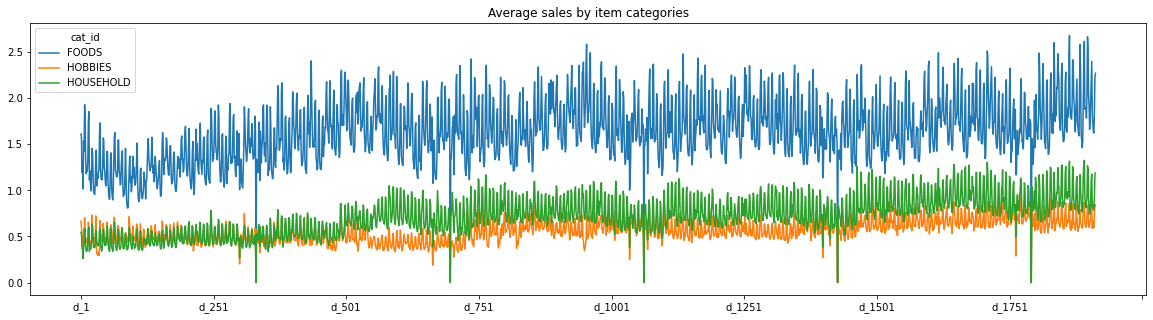

In [8]:
# number of sales by item catergories

validation.groupby('cat_id').mean().T.plot(figsize = (20,5), title = 'Average sales by item categories')

<AxesSubplot:title={'center':'Total sales by item categories'}>

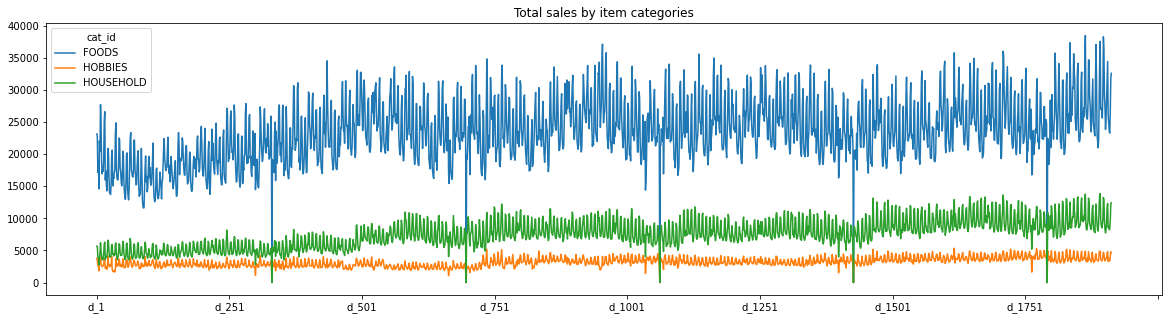

In [9]:
validation.groupby('cat_id').sum().T.plot(figsize=(20,5), title = 'Total sales by item categories')

<AxesSubplot:title={'center':'Total number of sales'}, xlabel='cat_id'>

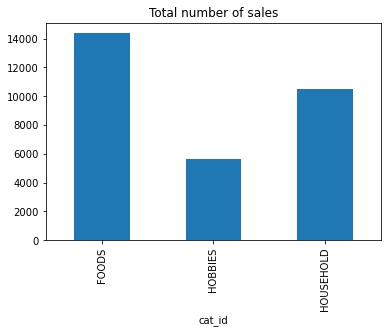

In [10]:
# counting the number of rows for each cat_id.
validation.groupby('cat_id').count()['id'].plot(kind='bar', title = 'Total number of sales')

#### Visualize by store categories

In this part, we want to plot, not the number of sales, but the frequency of the sales. 

We are going to use 'clip' method to set 1 if the item has been sold and 0 if not.

In [11]:
# tranpose the validation data and merge it with calendar data.
df_val_transposed = validation.set_index('id').T
df_val_transposed.index.rename('d', inplace = True)

df_validation_cal = pd.merge(df_val_transposed, calendar, on = 'd').set_index('date')

# extract only the item columns
item_col = np.array(validation['id'])
item_col

df_validation_cal = df_validation_cal[item_col]

In [12]:
# 'clip' a range of values from 0 to 1 with threshold (0,1) b/c we only want to see if the item has been sold (1) or not (0)
df_validation_cliped = df_validation_cal.clip(0,1)


In [13]:
df_validation_cliped

HOBBIES_1_001_CA_1_validation HOBBIES_1_002_CA_1_validation  \
date                                                                     
2011-01-29                             0                             0   
2011-01-30                             0                             0   
2011-01-31                             0                             0   
2011-02-01                             0                             0   
2011-02-02                             0                             0   
...                                  ...                           ...   
2016-04-20                             1                             1   
2016-04-21                             1                             0   
2016-04-22                             0                             0   
2016-04-23                             1                             0   
2016-04-24                             1                             0   

           HOBBIES_1_003_CA_1_validation HOBBIES_1_004_CA_1_validation  \
date                                                                     
2011-01-29                             0                             0   
2011-01-30                             0                             0   
2011-01-31                             0                             0   
2011-02-01                             0                             0   
2011-02-02                             0                             0   
...                                  ...                           ...   
2016-04-20                             1                             0   
2016-04-21                             0                             1   
2016-04-22                             1                             1   
2016-04-23                             1                             1   
2016-04-24                             1                             1   

           HOBBIES_1_005_CA_1_validation HOBBIES_1_006_CA_1_validation  \
date                                                                     
2011-01-29                             0                             0   
2011-01-30                             0                             0   
2011-01-31                             0                             0   
2011-02-01                             0                             0   
2011-02-02                             0                             0   
...                                  ...                           ...   
2016-04-20                             1                             0   
2016-04-21                             1                             0   
2016-04-22                             1                             1   
2016-04-23                             1                             0   
2016-04-24                             1                             0   

           HOBBIES_1_007_CA_1_validation HOBBIES_1_008_CA_1_validation  \
date                                                                     
2011-01-29                             0                             1   
2011-01-30                             0                             1   
2011-01-31                             0                             0   
2011-02-01                             0                             0   
2011-02-02                             0                             0   
...                                  ...                           ...   
2016-04-20                             1                             1   
2016-04-21                             0                             1   
2016-04-22                             0                             1   
2016-04-23                             1                             1   
2016-04-24                             1                             1   

           HOBBIES_1_009_CA_1_validation HOBBIES_1_010_CA_1_validation  ...  \
date                                                                    ...   
2

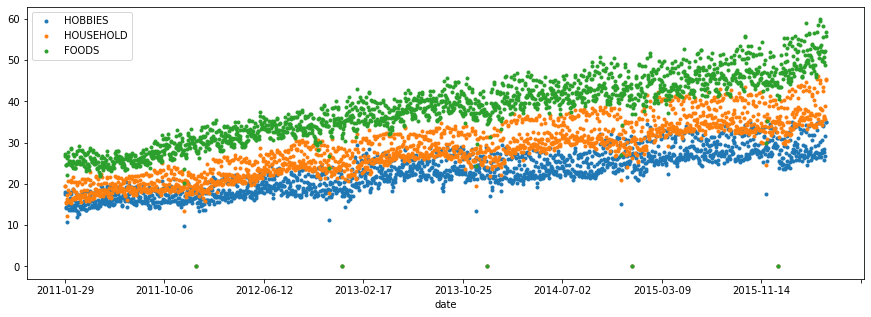

In [14]:
# plot the frequency of the sales
cat_id = validation['cat_id'].unique()
for i in cat_id:
    items = [c for c in df_validation_cliped.columns if i in c]
    (df_validation_cliped[items].mean(axis=1)*100).plot(figsize=(15,5),style = '.')
plt.legend(cat_id)

From the above graph, it is noticeable that the frequency of food was steady throughout the year as demand for food would be constant, but that of household item was low in the winter season as people tend to buy those items when it is not too cold. 

Hobbies items arguably displays low frequency of sales in the winter as well, but not as obvious as that of household item.

In [17]:
date_col = calendar.iloc[:,0]
date_col

0       2011-01-29
1       2011-01-30
2       2011-01-31
3       2011-02-01
4       2011-02-02
           ...    
1964    2016-06-15
1965    2016-06-16
1966    2016-06-17
1967    2016-06-18
1968    2016-06-19
Name: date, Length: 1969, dtype: object

### Price data

In [19]:
price = pd.read_csv('./raw_data/sell_prices.csv')
price = reduce_mem_usage(price)

Memory usage decreased to 130.48 Mb (37.5% reduction)


In [62]:
stores = price['store_id'].unique()
stores

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

Plot the moving averages with window size 90 for 10 different stores.

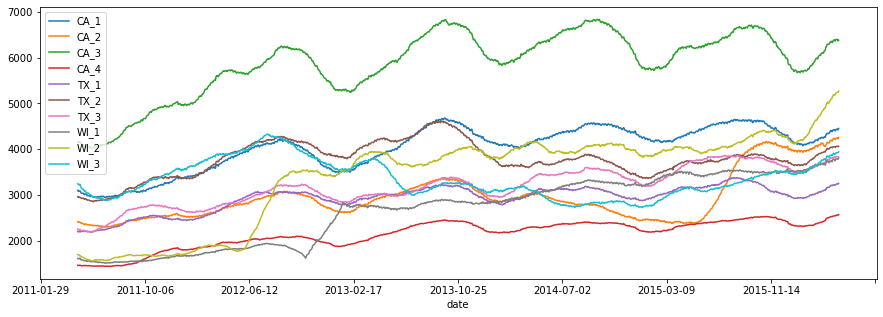

In [63]:
# Moving Average with window size 90
for store in stores:
    items = [c for c in df_validation_cal.columns if store in c]
    df_validation_cal[items].sum(axis = 1).rolling(90).mean().plot(figsize = (15,5))
plt.legend(stores)

Above graph corresponds to the business cycle, where the oscillation is driven by economic recession and expansion, but the general trend is upward sloping. 

It is important to note that the pattern is cyclical in the analysis.

## Data Preprocessing

We change the date column by grouping into the six categories and remove date and weekday columns.

In [15]:
# change the date to group

dict_day_to_group = {
    1:1, 2:1, 3:1, 4:1, 5:1,
    6:2, 7:2, 8:2, 9:2, 10:2,
    11:3, 12:3, 13:3, 14:3, 15:3,
    16:4, 17:4, 18:4, 19:4, 20:4,
    21:5, 22:5, 23:5, 24:5, 25:5,
    26:6, 27:6, 28:6, 29:6, 30:6, 31:6  
}

calendar['group_day'] = calendar['date'].str[-2:].apply(int).map(dict_day_to_group)
calendar = calendar.drop(['date','weekday'], axis=1)
calendar = calendar.rename(columns={'d':'day'})

obtain 34 unique dummy variables and drop event names and types.

In [16]:
calendar = pd.concat([calendar, pd.get_dummies(calendar[['event_name_1','event_name_2']])], axis=1)
calendar = calendar.drop(['event_name_1','event_name_2','event_type_1','event_type_2'], axis=1)

Here, we assign weights to the day of the events AND upto previous 30 days of the events.

(i.e assign 30 to the event day and 15 to previous 15th day of the event, for example)

In [17]:
for col in [c for c in calendar.columns.tolist() if 'event_name' in c]:
    days_event = np.where(calendar[col] == 1)[0].tolist()
    calendar[col] = calendar['day']

    dict_days_event = {}
    for d in days_event:
        for i in range(0, 30):
            dict_days_event['d_'+str(d-i)] = 30-i
    calendar[col] = calendar[col].map(dict_days_event).fillna(0)

In [18]:
# sum the weights of the events
calendar['event_sum'] = calendar[[c for c in calendar.columns.tolist() if 'event_name' in c]].sum(axis=1).tolist()

In [19]:
# save the processed calendar data
calendar.to_csv('./proc_data/processed_calendar.csv', index=False)

## Melt, Merge and Encode Data

In [20]:
pd.options.display.max_columns = 50

import random
from  datetime import datetime, timedelta

import lightgbm as lgb

In [21]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category",
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32",
                "rm_diff_price_4":"float32", "rm_diff_price_12":"float32","rm_diff_price_50":"float32" }
PROC_PRICES_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16",
                        "rm_diff_price_4":"float32", "rm_diff_price_12":"float32","rm_diff_price_50":"float32" }


In [22]:
h = 28
max_lags = 70
tr_last = 1941
fday = datetime(2016,5, 23)
fday


def create_dt(is_train=True, nrows=None, first_day=1200, dept='HOBBIES_1'):
    prices = pd.read_csv("./raw_data/sell_prices.csv", dtype=PRICE_DTYPES)

# encode the categorical variables
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()

    cal = pd.read_csv("./raw_data/calendar.csv", dtype=CAL_DTYPES)
    proc_cal = pd.read_csv('./proc_data/processed_calendar.csv').drop(
        ['wm_yr_wk', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI'], axis=1).rename(columns={'day': 'd'})
    cols_events_days = ['d_{}'.format(c) for c in list(np.arange(1910, 1990))]
    ev1 = cal[cal['d'].isin(cols_events_days)]['event_name_1'].unique().tolist()
    ev2 = cal[cal['d'].isin(cols_events_days)]['event_name_2'].unique().tolist()
    evs = list(set(ev1 + ev2))
    for c in list(set(proc_cal.columns.tolist()) - set(['d'])):
        proc_cal[c] = proc_cal[c].astype(int)
    cal = cal.merge(proc_cal, on='d', how='left')
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()      
    events_to_mantain = ['event_name_1_{}'.format(c) for c in evs] + ['event_name_2_{}'.format(c) for c in evs]
    events_to_mantain_ = [c for c in cal.columns if c in events_to_mantain]

    cal = cal[
        ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
         'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'group_day'] + events_to_mantain_]

    start_day = max(1 if is_train else tr_last - max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day, tr_last + 1)]
    catcols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
    dtype = {numcol: "float32" for numcol in numcols}
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("./raw_data/sales_train_evaluation.csv",
                     nrows=nrows, usecols=catcols + numcols, dtype=dtype)
    dt = dt[dt['dept_id'] == dept]

    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()

    if not is_train:
        for day in range(tr_last + 1, tr_last + 28 + 1):
            dt[f"d_{day}"] = np.nan

    dt = pd.melt(dt,
                 id_vars=catcols,
                 value_vars=[col for col in dt.columns if col.startswith("d_")],
                 var_name="d",
                 value_name="sales")

    dt = dt.merge(cal, on="d", copy=False)
    dt = dt.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], copy=False)

    return dt


## Modeling

In [23]:
# create features
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id", "sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(
                lambda x: x.rolling(win).mean())

    date_features = {

        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
        #         "ime": "is_month_end",
        #         "ims": "is_month_start",
    }

    #     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")


In [37]:
FIRST_DAY = 350

sub_p_total = pd.DataFrame()
for dept in ['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3']:
    # for dept in ['HOBBIES_1']:

    df = create_dt(is_train=True, first_day=FIRST_DAY, dept=dept)
    print(df.shape)

    create_fea(df)
    print(df.shape)
    print(df.columns)

    for c in [c for c in df.columns.tolist() if 'rm_diff_price_' in c]:
        df[c].fillna(0, inplace=True)

    # df.dropna(inplace = True)
    df.shape

    cat_feats = (['item_id', 'store_id', 'cat_id', 'state_id']
                 + ["event_type_1", "event_type_2"]
                 + ['wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI'])

    useless_cols = ["id", "date", "sales", "d",'wm_yr_wk', "weekday", "dept_id", "sell_price", 'event_name_1',
                    'event_name_2']
    train_cols = df.columns[~df.columns.isin(useless_cols)]

    # days_val = df['d'].unique().tolist()[-200:]
    days_val = random.choices(df['d'].unique().tolist(), k=500)
    X_train = df[df['d'].isin(days_val) == False][train_cols]
    y_train = df[df['d'].isin(days_val) == False]["sales"]
    X_val = df[df['d'].isin(days_val) == True][train_cols]
    y_val = df[df['d'].isin(days_val) == True]["sales"]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_feats)

    params = {
        "objective": "poisson",
        "metric": "poisson",
        "learning_rate": 0.09,
        "sub_feature": 0.9,
        "sub_row": 0.75,
        "bagging_freq": 1,
        "lambda_l2": 0.1,
        'verbosity': 1,
        'num_iterations': 2000,
        'num_leaves': 32,
        "min_data_in_leaf": 50,
    }

    m_lgb = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                      verbose_eval=20, early_stopping_rounds=30)

    feature_imp = pd.DataFrame({'Value': m_lgb.feature_importance(), 'Feature': X_train.columns})
    feature_imp = feature_imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

    te = create_dt(False, dept=dept)
    cols = [f"F{i}" for i in range(1, 29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day, train_cols]
        te.loc[te.date == day, "sales"] = m_lgb.predict(tst)
        del (tst)

    del (m_lgb)
    sub_p = pd.pivot_table(te, index='id', values='sales', columns='d').iloc[:, -28:].reset_index()
    del (te)
    sub_p_total = pd.concat([sub_p_total, sub_p])
    del (sub_p)


(5869396, 35)
(5869396, 44)
Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'group_day',
       'event_name_1_Cinco De Mayo', 'event_name_1_Father's day',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_Ramadan starts', 'event_name_2_Cinco De Mayo',
       'event_name_2_Father's day', 'event_name_2_OrthodoxEaster',
       'sell_price', 'lag_7', 'lag_28', 'rmean_7_7', 'rmean_28_7',
       'rmean_7_28', 'rmean_28_28', 'week', 'quarter', 'mday'],
      dtype='object')
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[780]	training's poisson: 0.37609	valid_1's poisson: 0.403579
[800]	training's poisson: 0.375714	valid_1's poisson: 0.403554
[820]	training's poisson: 0.375335	valid_1's poisson: 0.403526
[840]	training's poisson: 0.374906	valid_1's poisson: 0.403501
[860]	training's poisson: 0.374538	valid_1's poisson: 0.403481
[880]	training's poisson: 0.374154	valid_1's poisson: 0.40347
[900]	training's poisson: 0.373783	valid_1's poisson: 0.403418
[920]	training's poisson: 0.373437	valid_1's poisson: 0.4034
[940]	training's poisson: 0.373087	valid_1's poisson: 0.403373
[960]	training's poisson: 0.372749	valid_1's poisson: 0.403315
[980]	training's poisson: 0.372398	valid_1's poisson: 0.403275
[1000]	training's poisson: 0.372049	valid_1's poisson: 0.403264
[1020]	training's poisson: 0.371694	valid_1's poisson: 0.403245
[1040]	training's poisson: 0.371356	valid_1's poisson: 0.403207
[1060]	training's poisson: 0.371037	valid_1's poisson: 0.403207
[1080]	training's poisson: 0.370693	valid_1's poisson: 

[1260]	training's poisson: -0.14756	valid_1's poisson: -0.115148
[1280]	training's poisson: -0.147813	valid_1's poisson: -0.115277
[1300]	training's poisson: -0.148081	valid_1's poisson: -0.11543
[1320]	training's poisson: -0.14836	valid_1's poisson: -0.115593
[1340]	training's poisson: -0.148674	valid_1's poisson: -0.115794
[1360]	training's poisson: -0.148948	valid_1's poisson: -0.115976
[1380]	training's poisson: -0.149233	valid_1's poisson: -0.116133
[1400]	training's poisson: -0.14951	valid_1's poisson: -0.116286
[1420]	training's poisson: -0.149755	valid_1's poisson: -0.116423
[1440]	training's poisson: -0.149987	valid_1's poisson: -0.116557
[1460]	training's poisson: -0.150254	valid_1's poisson: -0.116691
[1480]	training's poisson: -0.150554	valid_1's poisson: -0.116882
[1500]	training's poisson: -0.150806	valid_1's poisson: -0.117003
[1520]	training's poisson: -0.151033	valid_1's poisson: -0.117142
[1540]	training's poisson: -0.151314	valid_1's poisson: -0.117302
[1560]	trainin

[1160]	training's poisson: 0.47315	valid_1's poisson: 0.48236
[1180]	training's poisson: 0.473051	valid_1's poisson: 0.482319
[1200]	training's poisson: 0.472949	valid_1's poisson: 0.482278
[1220]	training's poisson: 0.472846	valid_1's poisson: 0.48222
[1240]	training's poisson: 0.472736	valid_1's poisson: 0.482172
[1260]	training's poisson: 0.472637	valid_1's poisson: 0.482136
[1280]	training's poisson: 0.47254	valid_1's poisson: 0.482101
[1300]	training's poisson: 0.472441	valid_1's poisson: 0.482074
[1320]	training's poisson: 0.472328	valid_1's poisson: 0.482026
[1340]	training's poisson: 0.472232	valid_1's poisson: 0.481992
[1360]	training's poisson: 0.472126	valid_1's poisson: 0.48195
[1380]	training's poisson: 0.472019	valid_1's poisson: 0.481905
[1400]	training's poisson: 0.471931	valid_1's poisson: 0.481879
[1420]	training's poisson: 0.47183	valid_1's poisson: 0.481846
[1440]	training's poisson: 0.471744	valid_1's poisson: 0.48182
[1460]	training's poisson: 0.47166	valid_1's po

[1060]	training's poisson: -0.212969	valid_1's poisson: -0.175559
[1080]	training's poisson: -0.213566	valid_1's poisson: -0.175814
[1100]	training's poisson: -0.214217	valid_1's poisson: -0.176187
[1120]	training's poisson: -0.214796	valid_1's poisson: -0.17644
[1140]	training's poisson: -0.215458	valid_1's poisson: -0.176813
[1160]	training's poisson: -0.215987	valid_1's poisson: -0.177031
[1180]	training's poisson: -0.216565	valid_1's poisson: -0.177317
[1200]	training's poisson: -0.217114	valid_1's poisson: -0.177614
[1220]	training's poisson: -0.21763	valid_1's poisson: -0.177832
[1240]	training's poisson: -0.218241	valid_1's poisson: -0.178154
[1260]	training's poisson: -0.218835	valid_1's poisson: -0.178415
[1280]	training's poisson: -0.219351	valid_1's poisson: -0.178637
[1300]	training's poisson: -0.219897	valid_1's poisson: -0.178903
[1320]	training's poisson: -0.220401	valid_1's poisson: -0.179134
[1340]	training's poisson: -0.220923	valid_1's poisson: -0.179355
[1360]	train

[920]	training's poisson: 0.0377573	valid_1's poisson: 0.0492746
[940]	training's poisson: 0.0373358	valid_1's poisson: 0.049003
[960]	training's poisson: 0.0368864	valid_1's poisson: 0.0487167
[980]	training's poisson: 0.0364769	valid_1's poisson: 0.048462
[1000]	training's poisson: 0.0361234	valid_1's poisson: 0.0482494
[1020]	training's poisson: 0.0357213	valid_1's poisson: 0.0480032
[1040]	training's poisson: 0.0352955	valid_1's poisson: 0.04773
[1060]	training's poisson: 0.0348665	valid_1's poisson: 0.0474861
[1080]	training's poisson: 0.0344851	valid_1's poisson: 0.0472373
[1100]	training's poisson: 0.0341278	valid_1's poisson: 0.0470464
[1120]	training's poisson: 0.0337687	valid_1's poisson: 0.0468444
[1140]	training's poisson: 0.0333994	valid_1's poisson: 0.0466372
[1160]	training's poisson: 0.0330829	valid_1's poisson: 0.0464826
[1180]	training's poisson: 0.0326657	valid_1's poisson: 0.046222
[1200]	training's poisson: 0.0323229	valid_1's poisson: 0.0460323
[1220]	training's p

[800]	training's poisson: -1.59444	valid_1's poisson: -1.59828
[820]	training's poisson: -1.59522	valid_1's poisson: -1.5987
[840]	training's poisson: -1.59613	valid_1's poisson: -1.59925
[860]	training's poisson: -1.59695	valid_1's poisson: -1.5998
[880]	training's poisson: -1.59757	valid_1's poisson: -1.60009
[900]	training's poisson: -1.59852	valid_1's poisson: -1.60074
[920]	training's poisson: -1.59924	valid_1's poisson: -1.60122
[940]	training's poisson: -1.6	valid_1's poisson: -1.60167
[960]	training's poisson: -1.60076	valid_1's poisson: -1.60209
[980]	training's poisson: -1.60149	valid_1's poisson: -1.60251
[1000]	training's poisson: -1.60217	valid_1's poisson: -1.60293
[1020]	training's poisson: -1.60276	valid_1's poisson: -1.60322
[1040]	training's poisson: -1.60341	valid_1's poisson: -1.60357
[1060]	training's poisson: -1.6042	valid_1's poisson: -1.60406
[1080]	training's poisson: -1.60488	valid_1's poisson: -1.60446
[1100]	training's poisson: -1.60562	valid_1's poisson: -1

In [38]:
sub = pd.read_csv('./raw_data/sample_submission.csv', usecols=['id'])
sub = sub.merge(sub_p_total, on='id', how='left')
sub = sub.dropna()

In [39]:
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.columns = ['id'] + ['F' + str(c) for c in np.arange(1,29,1)]
sub.to_csv("./proc_data/partial_submission.csv",index=False)

## Compute mean error

In [40]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

from matplotlib import pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
cols_days = ['d_{}'.format(c) for c in range(1914,1942)]

In [42]:
df_eval = pd.read_csv('./raw_data/sales_train_evaluation.csv', usecols=['id','dept_id','store_id']+cols_days)
df_model = pd.read_csv('./proc_data/partial_submission.csv')

In [43]:
df_comparison = df_eval.merge(df_model, on='id', how='inner')

In [44]:
df_comparison.groupby(['dept_id','store_id']).mean()

d_1914    d_1915    d_1916    d_1917    d_1918  \
dept_id     store_id                                                     
FOODS_1     CA_1      1.361111  1.199074  1.240741  1.518519  1.791667   
            CA_2      2.032407  1.675926  2.060185  2.060185  2.212963   
            CA_3      2.087963  1.527778  1.912037  2.101852  1.787037   
            CA_4      1.078704  1.500000  1.046296  0.986111  1.180556   
            TX_1      1.013889  0.773148  0.916667  0.782407  1.115741   
            TX_2      1.000000  0.976852  0.958333  1.189815  1.365741   
            TX_3      1.009259  1.412037  1.379630  1.509259  1.981481   
            WI_1      1.125000  1.333333  1.208333  1.449074  1.819444   
            WI_2      1.393519  1.500000  1.250000  1.930556  2.666667   
            WI_3      1.050926  1.342593  0.986111  1.212963  1.671296   
FOODS_2     CA_1      1.150754  1.256281  1.035176  1.005025  1.163317   
            CA_2      1.115578  1.095477  0.902010  0.944724  1.057789   
            CA_3      1.716080  1.537688  1.331658  1.135678  1.567839   
            CA_4      1.025126  0.889447  0.763819  0.695980  0.801508   
            TX_1      0.698492  0.781407  0.643216  0.633166  0.967337   
            TX_2      1.173367  0.874372  0.773869  0.861809  0.947236   
            TX_3      1.211055  0.962312  0.864322  0.934673  1.236181   
            WI_1      1.374372  1.185930  1.203518  1.208543  1.457286   
            WI_2      1.869347  2.118090  1.957286  1.819095  2.291457   
            WI_3      1.120603  1.012563  0.854271  1.035176  1.005025   
FOODS_3     CA_1      2.601458  2.137303  2.171324  2.087485  2.651276   
            CA_2      2.151883  1.832321  1.725395  1.987849  2.383961   
            CA_3      3.611179  2.721750  2.783718  2.684083  3.029162   
            CA_4      1.458080  1.232078  1.319563  1.187120  1.390036   
            TX_1      1.829891  1.594168  1.817740  1.460510  2.004860   
            TX_2      2.236938  2.138518  2.070474  1.911300  2.383961   
            TX_3      2.098420  2.046173  1.873633  1.924666  2.340219   
            WI_1      1.724180  1.670717  1.794654  1.697448  2.188335   
            WI_2      2.294046  2.188335  1.996355  2.272175  2.522479   
            WI_3      2.053463  1.876063  1.842041  1.793439  2.064399   
HOBBIES_1   CA_1      1.312500  0.949519  1.004808  0.925481  1.322115   
            CA_2      0.793269  0.668269  0.800481  0.826923  0.923077   
            CA_3      1.151442  1.353365  0.908654  1.045673  1.146635   
            CA_4      0.939904  0.646635  1.028846  0.829327  0.661058   
            TX_1      0.492788  0.449519  0.538462  0.596154  0.598558   
            TX_2      0.846154  0.875000  0.593750  0.771635  0.901442   
            TX_3      0.694712  0.752404  0.776442  0.848558  0.891827   
            WI_1      0.884615  1.045673  1.002404  0.949519  0.939904   
            WI_2      0.560096  0.468750  0.591346  0.593750  0.807692   
            WI_3      0.471154  0.524038  0.533654  0.432692  0.579327   
HOBBIES_2   CA_1      0.288591  0.208054  0.221477  0.315436  0.228188   
            CA_2      0.208054  0.389262  0.181208  0.375839  0.362416   
            CA_3      0.536913  0.489933  0.677852  0.677852  0.530201   
            CA_4      0.107383  0.127517  0.100671  0.114094  0.087248   
            TX_1      0.322148  0.335570  0.261745  0.295302  0.248322   
            TX_2      0.348993  0.362416  0.523490  0.302013  0.302013   
            TX_3      0.241611  0.261745  0.557047  0.523490  0.503356   
            WI_1      0.174497  0.248322  0.201342  0.308725  0.281879   
            WI_2      0.187919  0.181208  0.255034  0.167785  0.147651   
            WI_3      0.221477  0.268456  0.335570  0.201342  0.234899   
HOUSEHOLD_1 CA_1      1.466165  1.095865  1.156015  1.037594  1.330827   
            CA_2      1.253759  1.191729  1.308271  1.154135  1.454887   
            CA_3      2.5300

In [45]:
df_comp_mean = df_comparison.groupby(['dept_id','store_id']).mean()

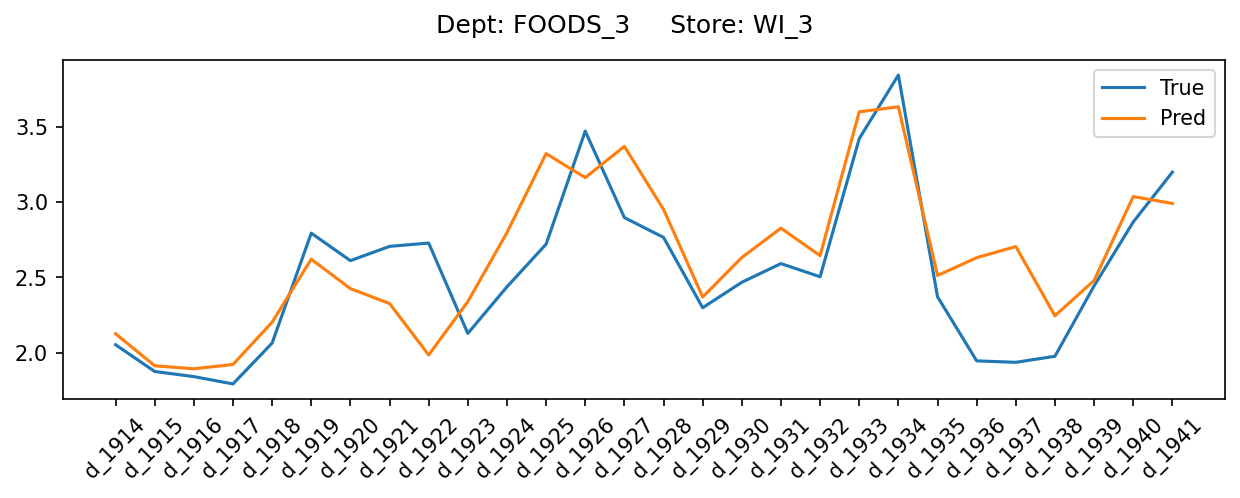

In [46]:
#for i in range(0, len(df_comp_mean)):

x = df_comp_mean.iloc[i,:28].index
y_true = df_comp_mean.iloc[i,:28].values
y_pred = df_comp_mean.iloc[i,28:].values
indice = df_comp_mean.index[i]

fig, ax = plt.subplots(figsize = (10,3), dpi=150)

fig.suptitle('Dept: {dept}     Store: {store}'.format(dept=indice[0], store=indice[1]))
ax.plot(x, y_true, label='True')
ax.plot(x, y_pred, label='Pred')
ax.tick_params(axis='x', rotation=45)

ax.legend()

plt.show()

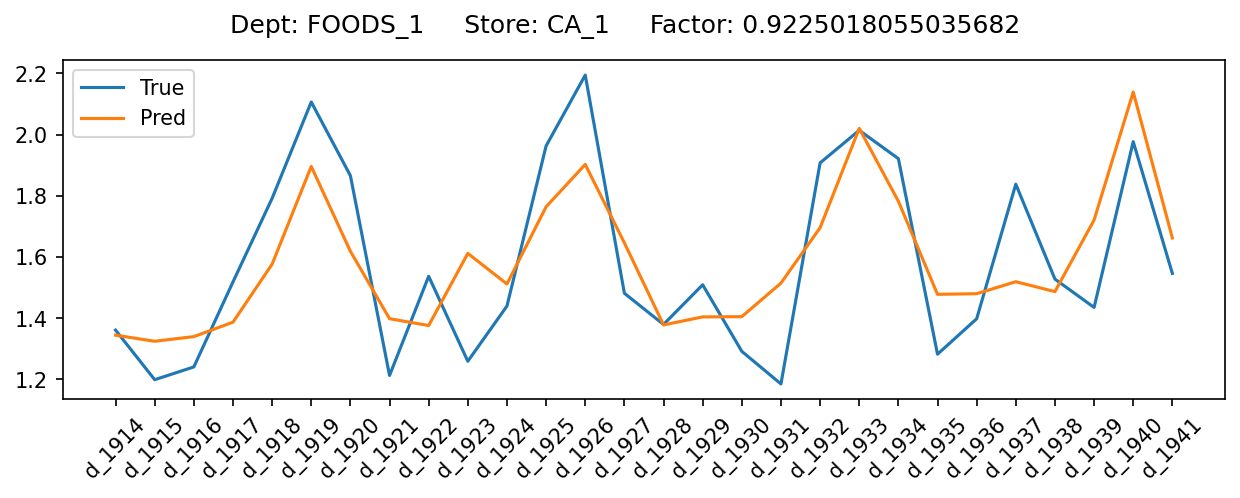

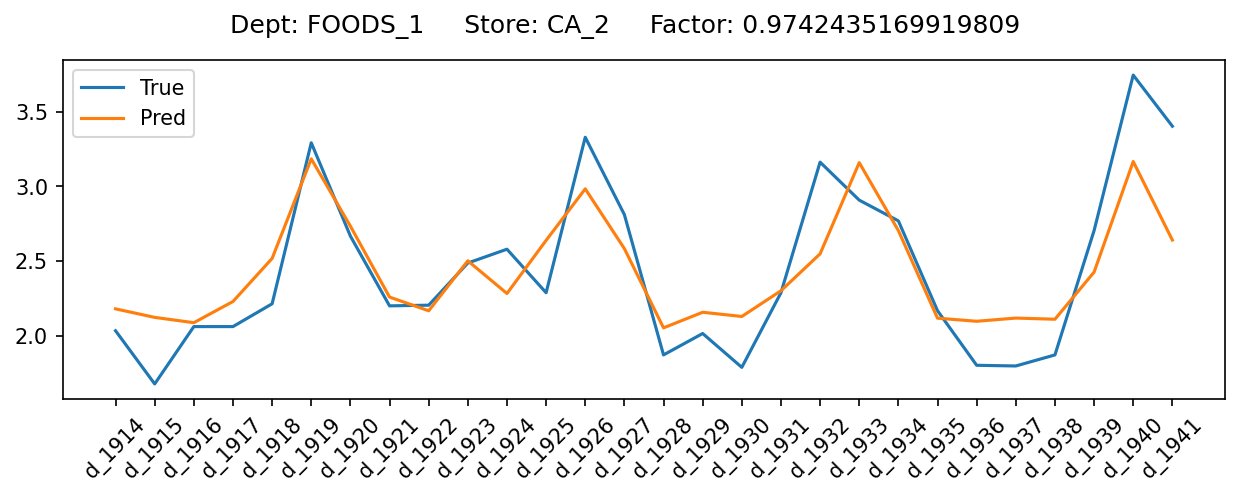

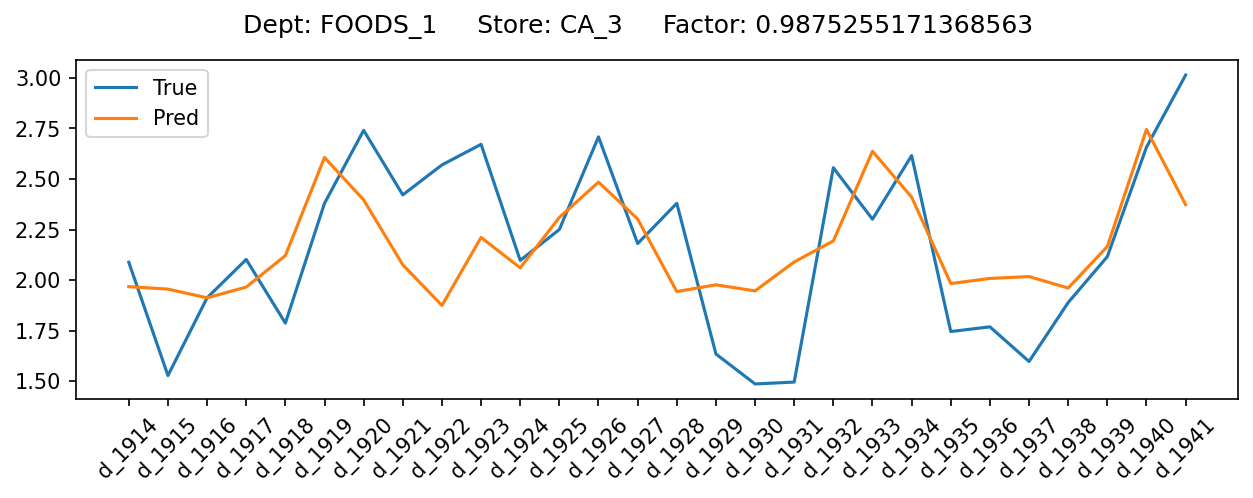

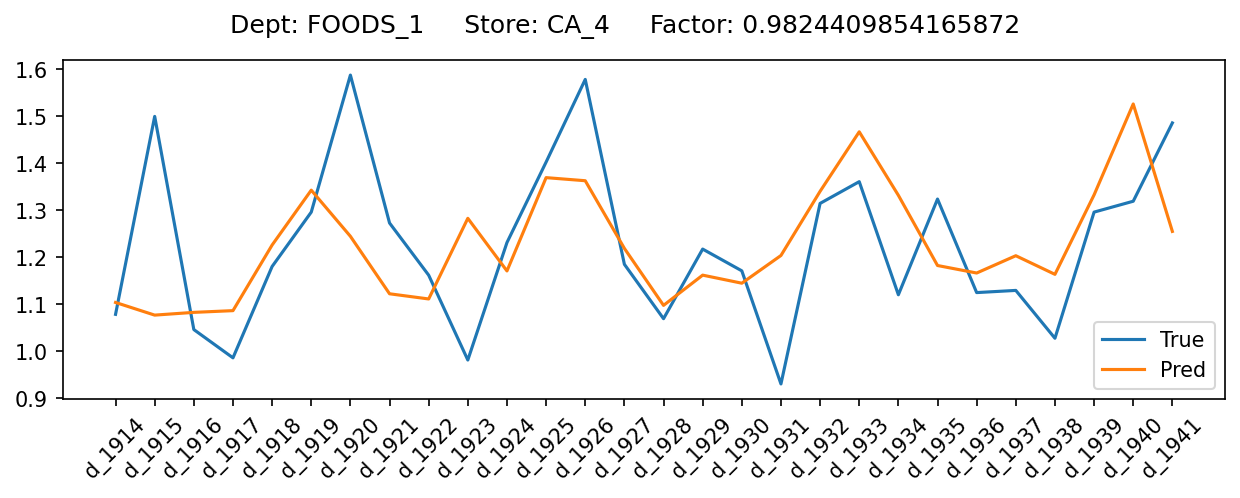

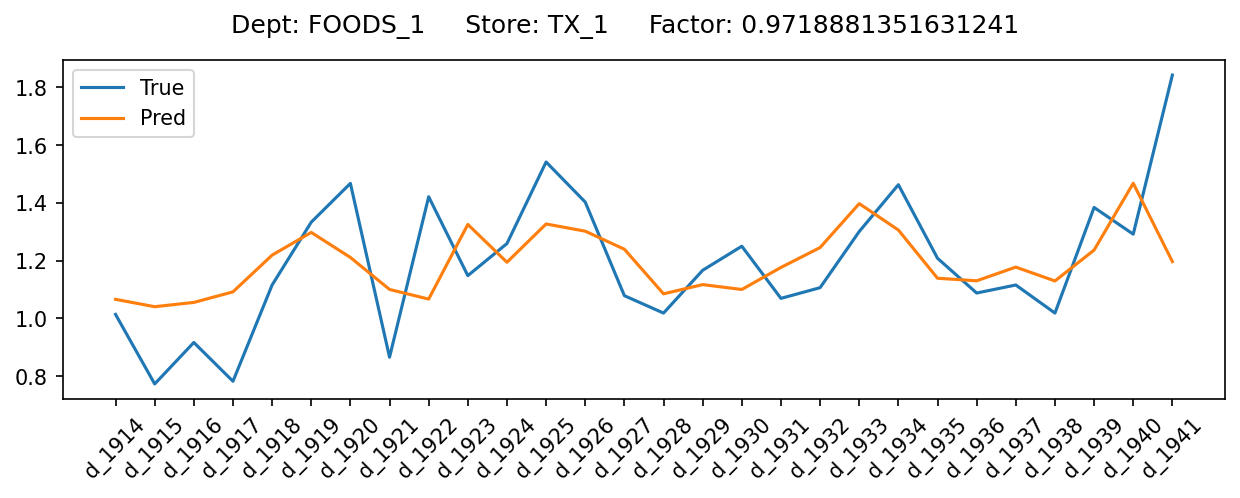

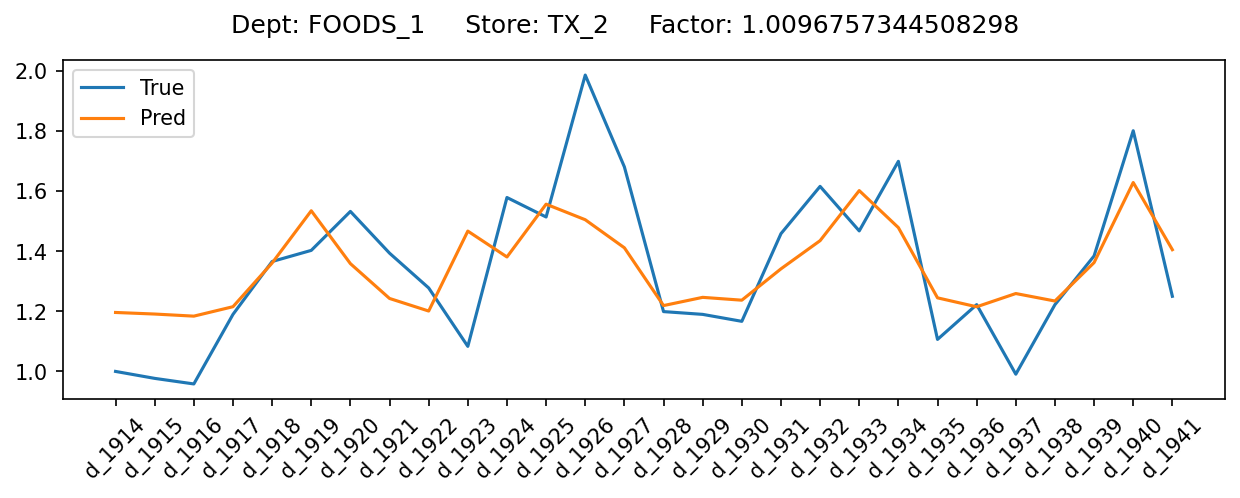

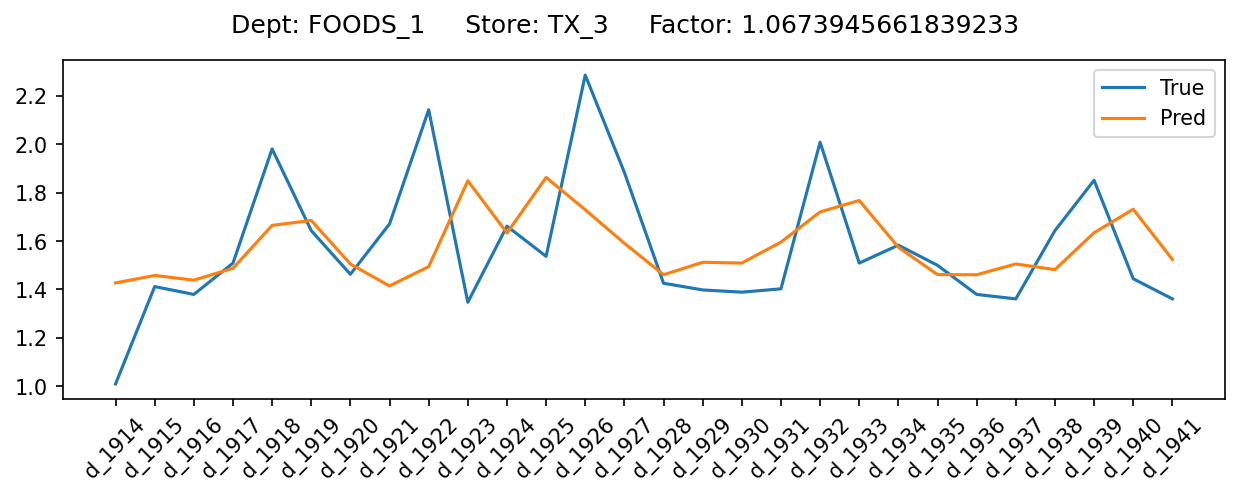

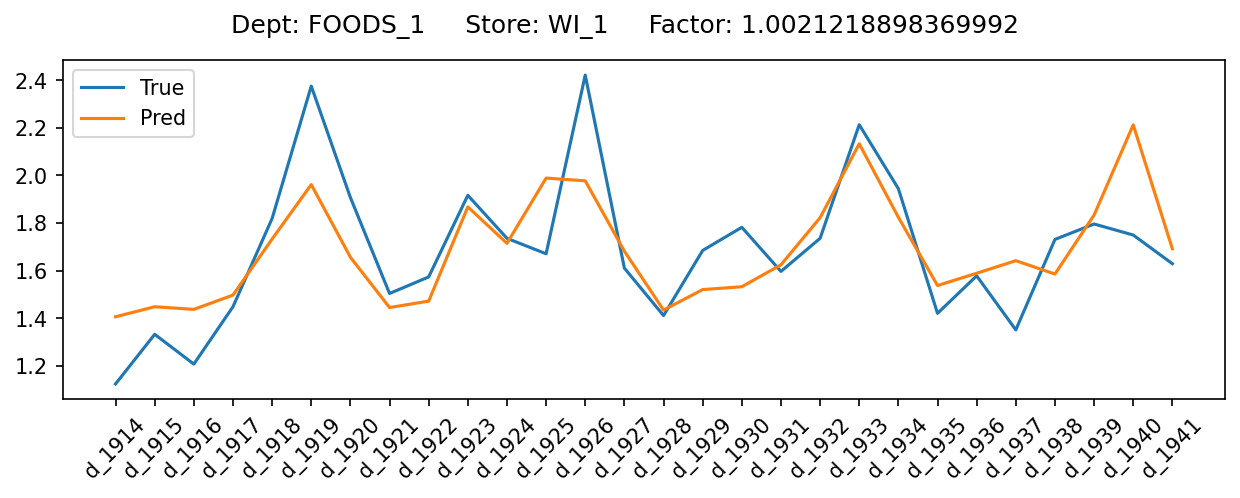

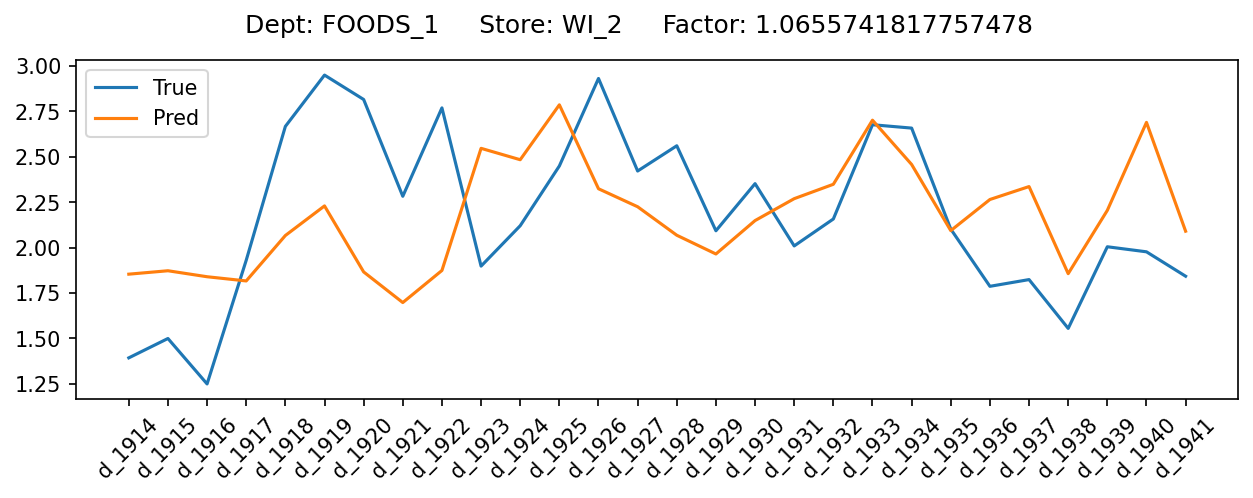

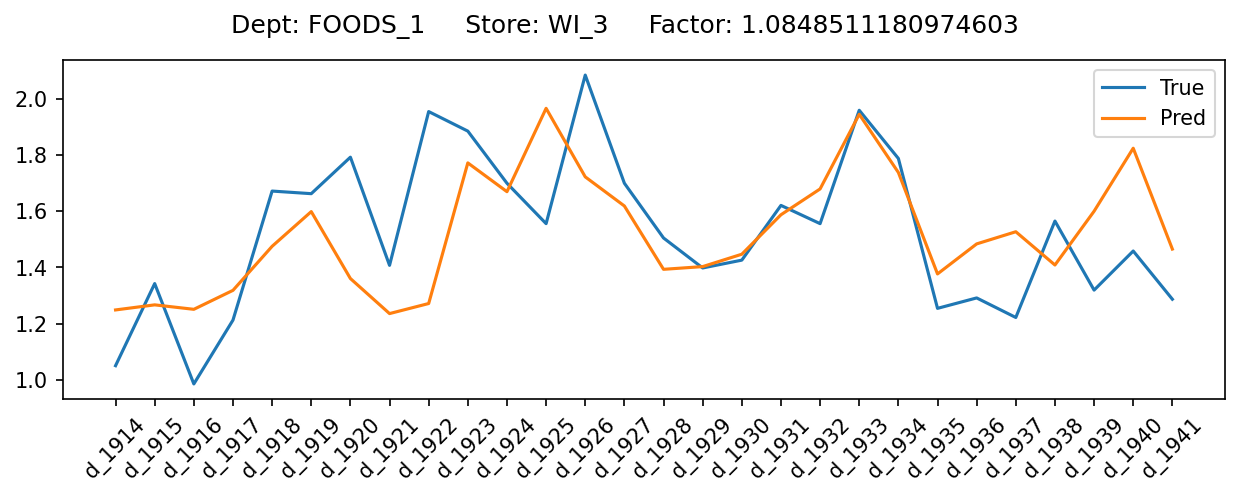

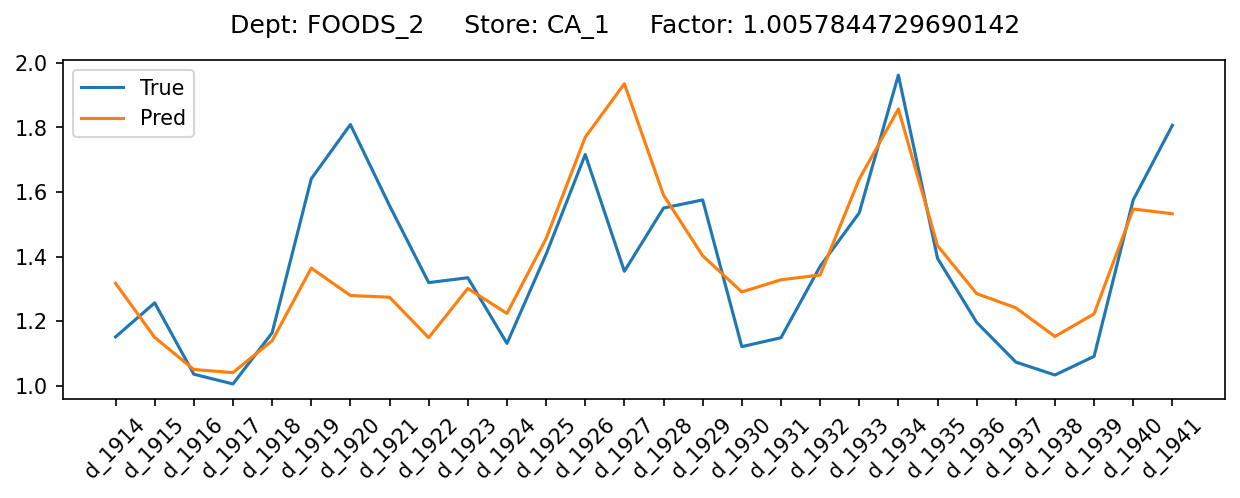

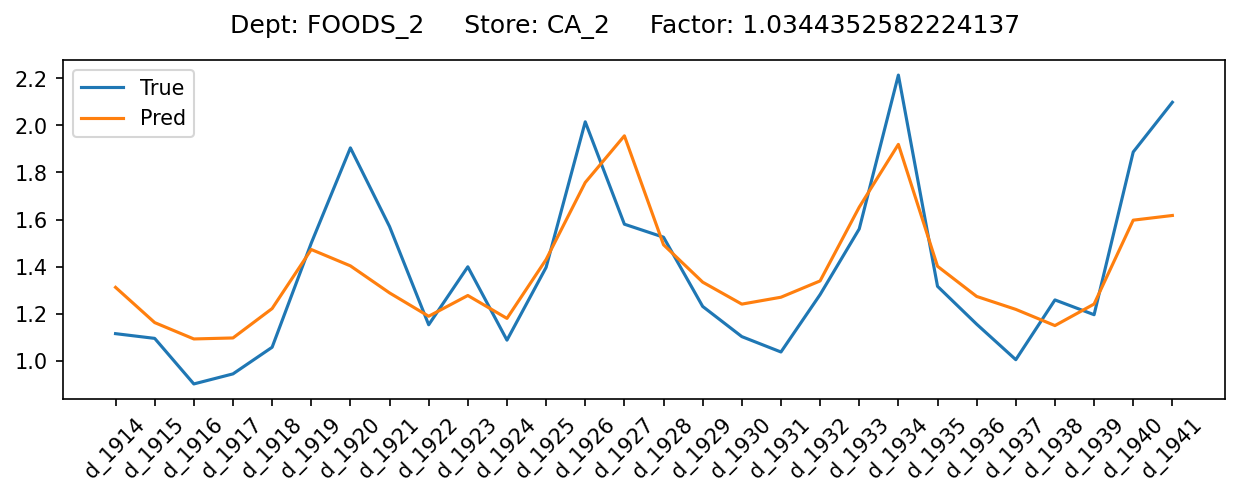

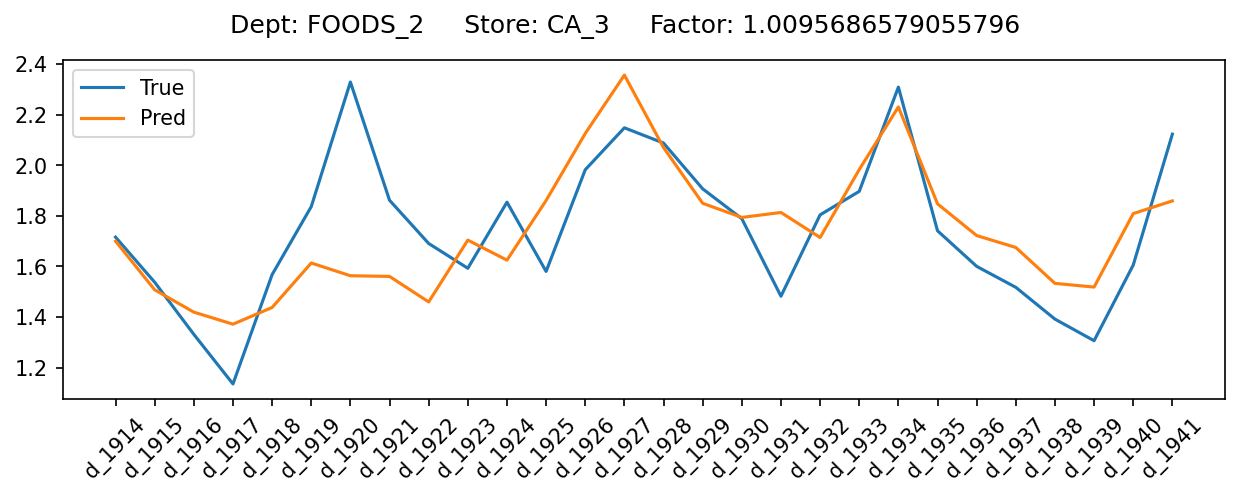

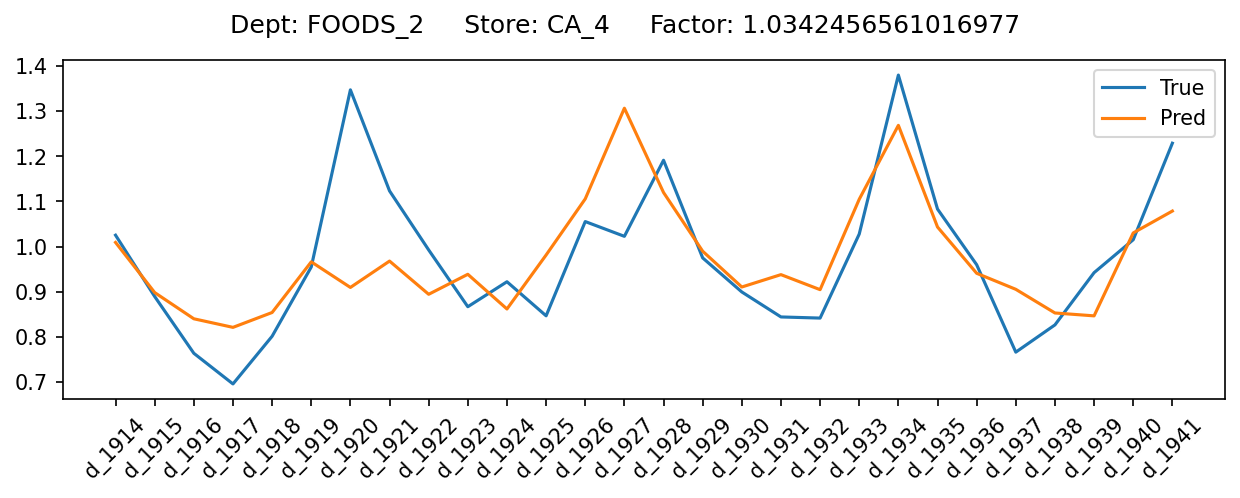

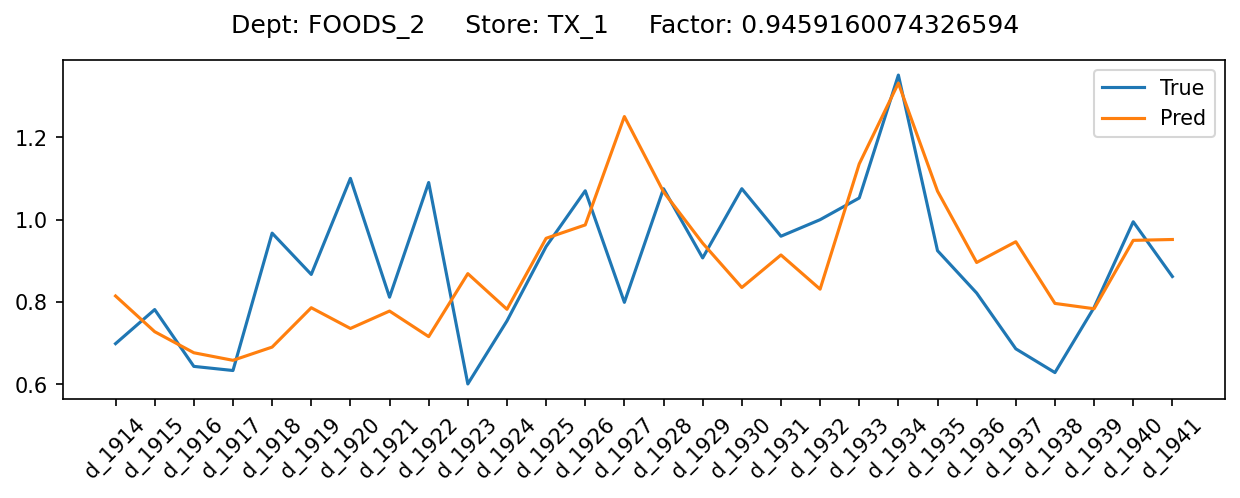

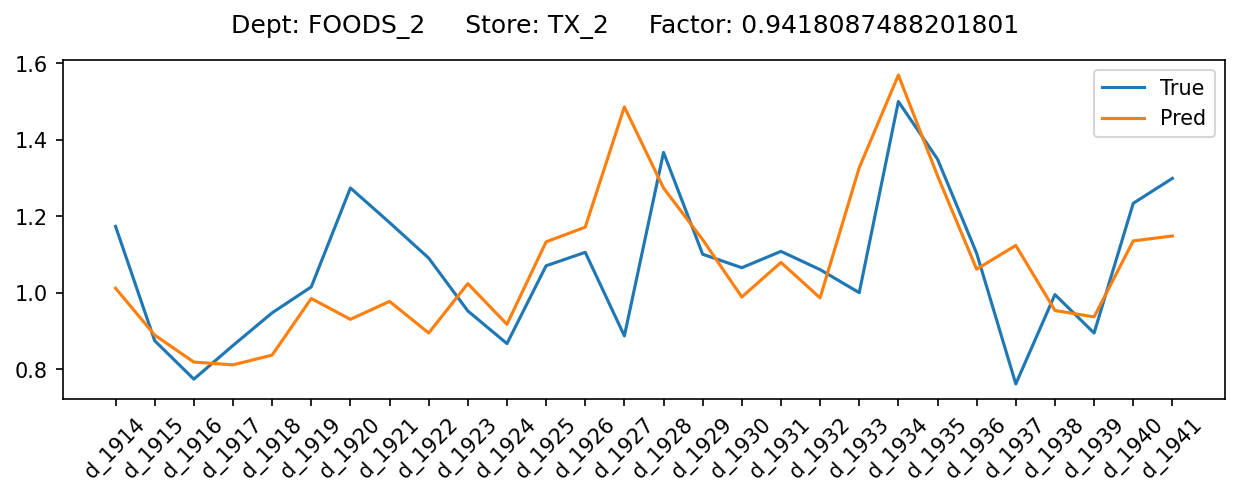

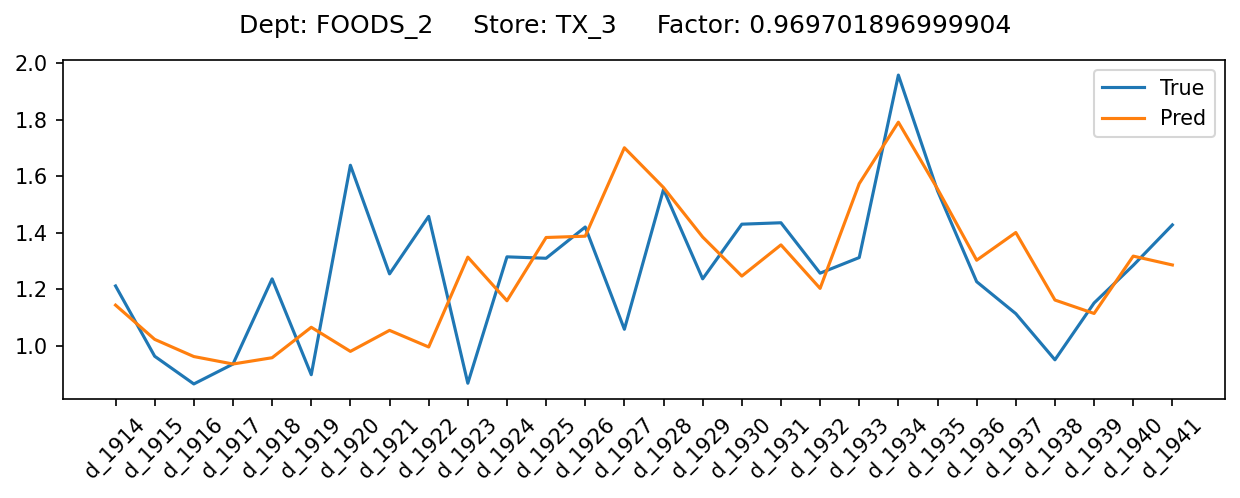

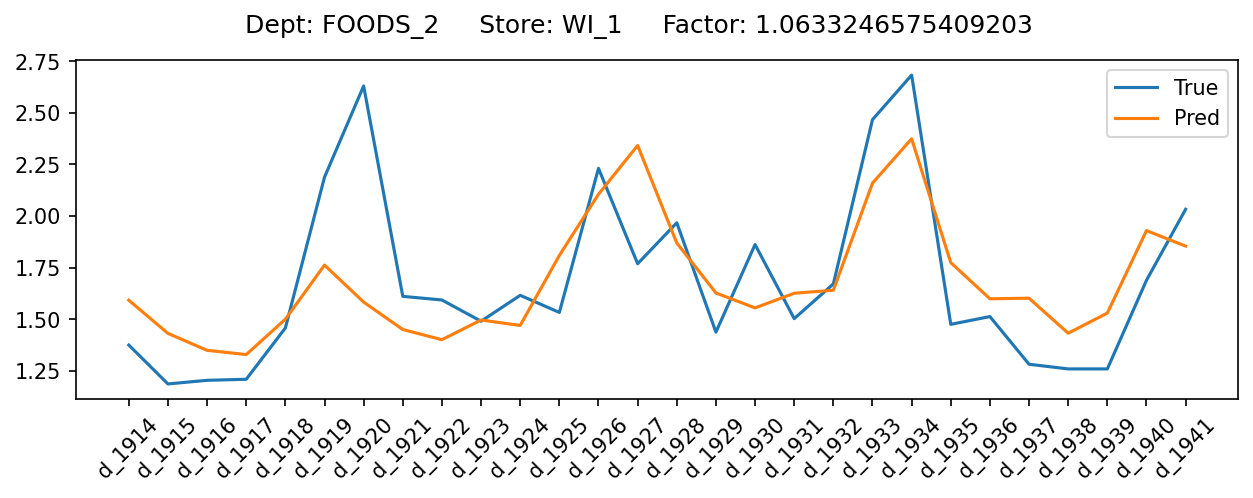

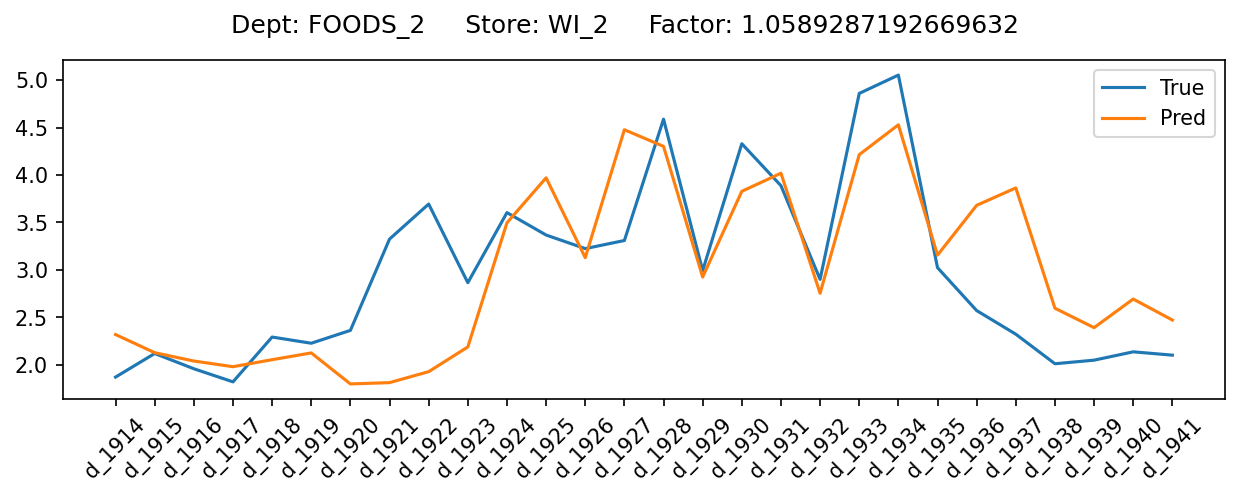

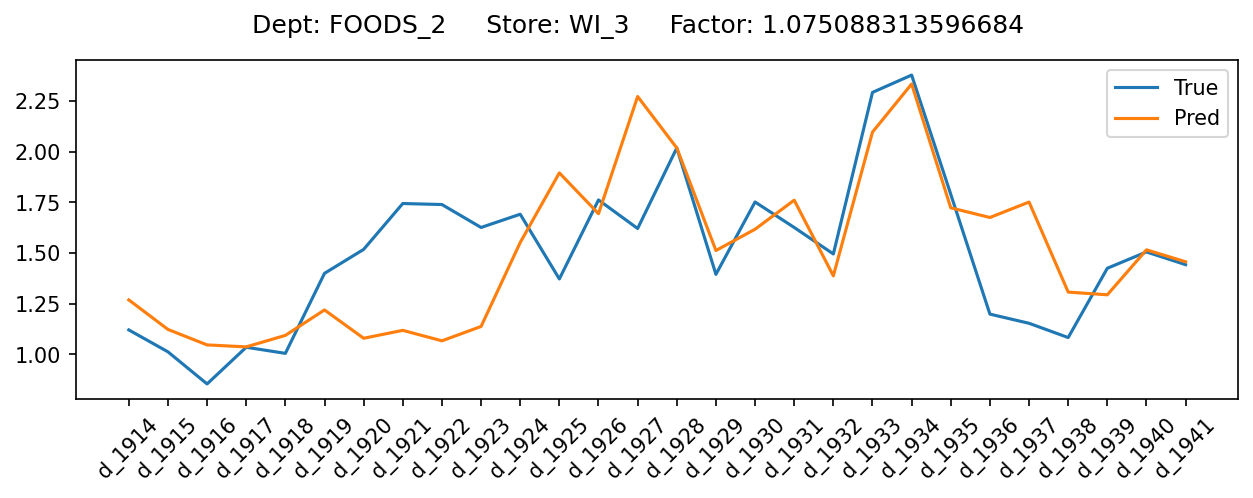

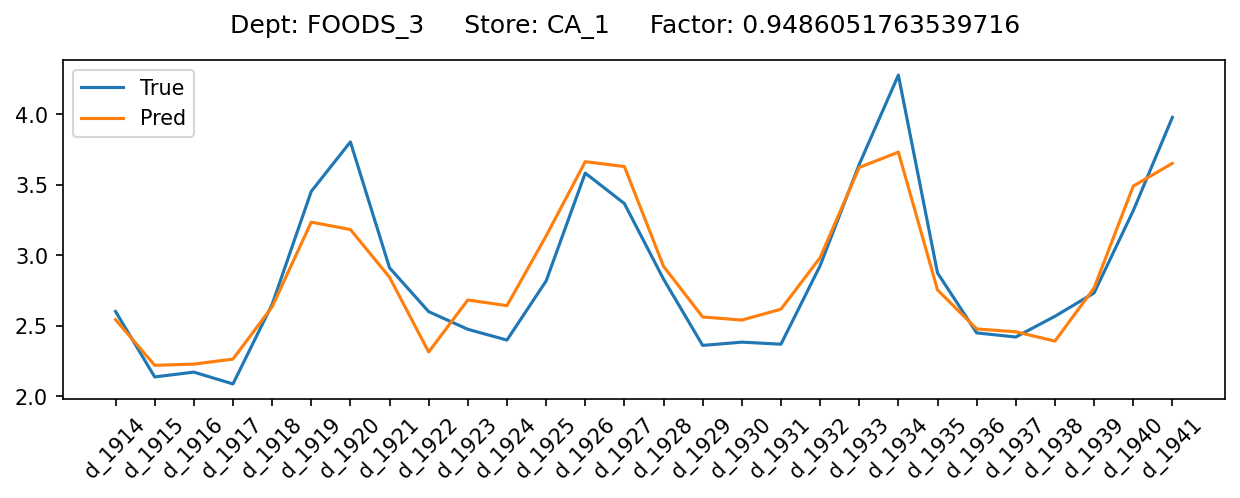

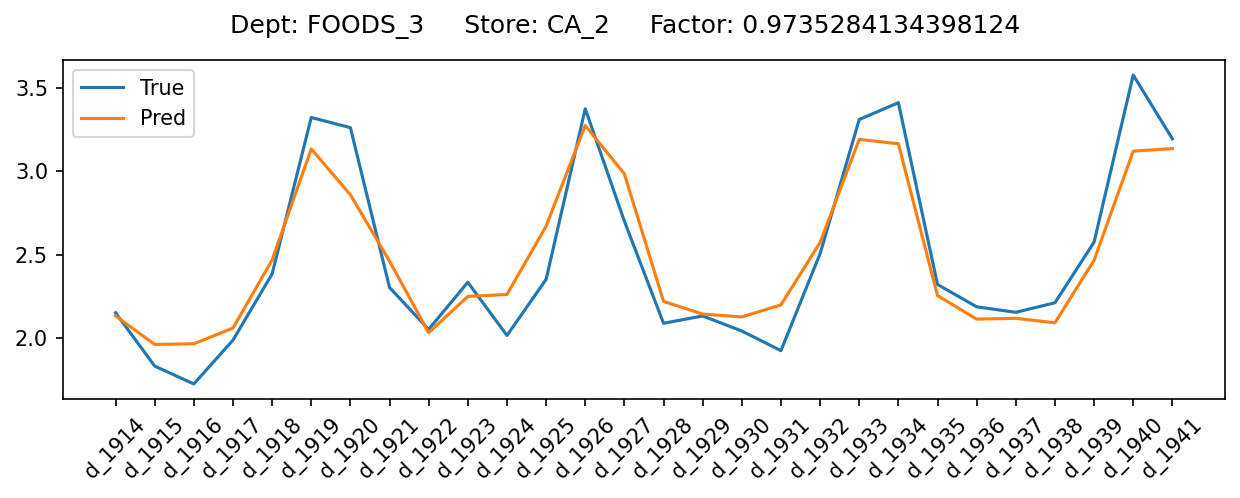

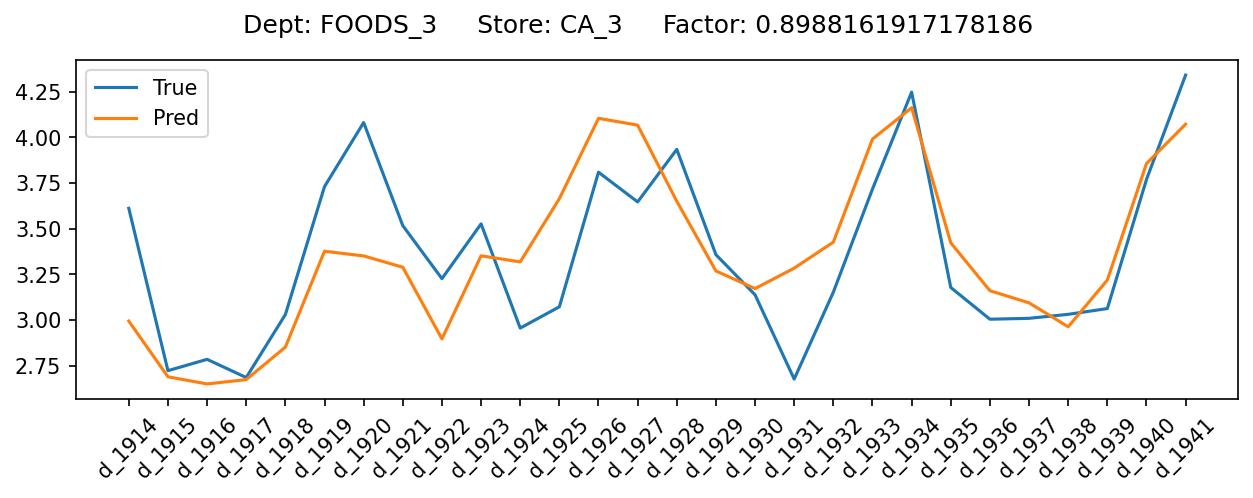

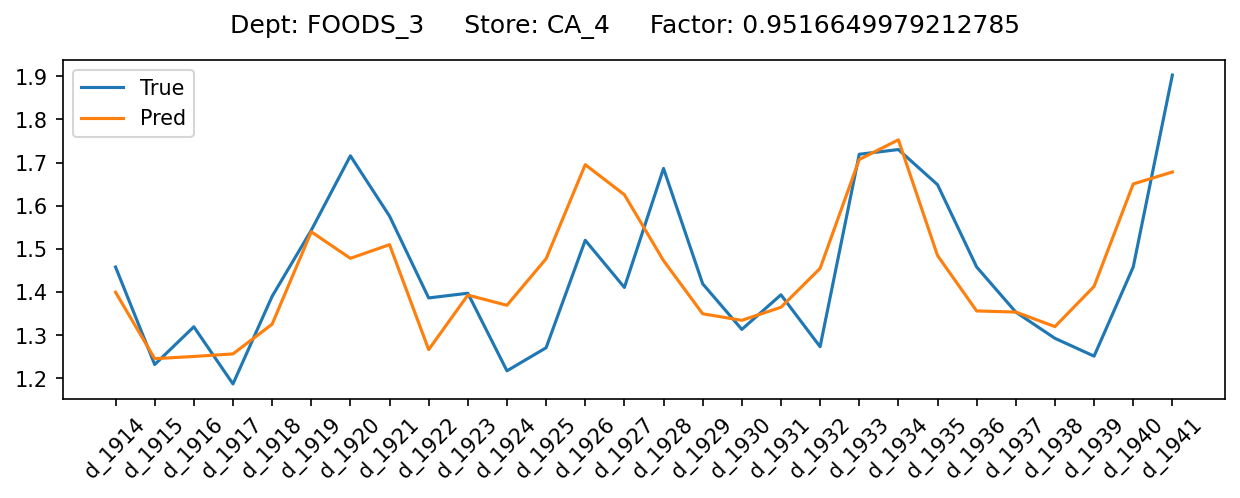

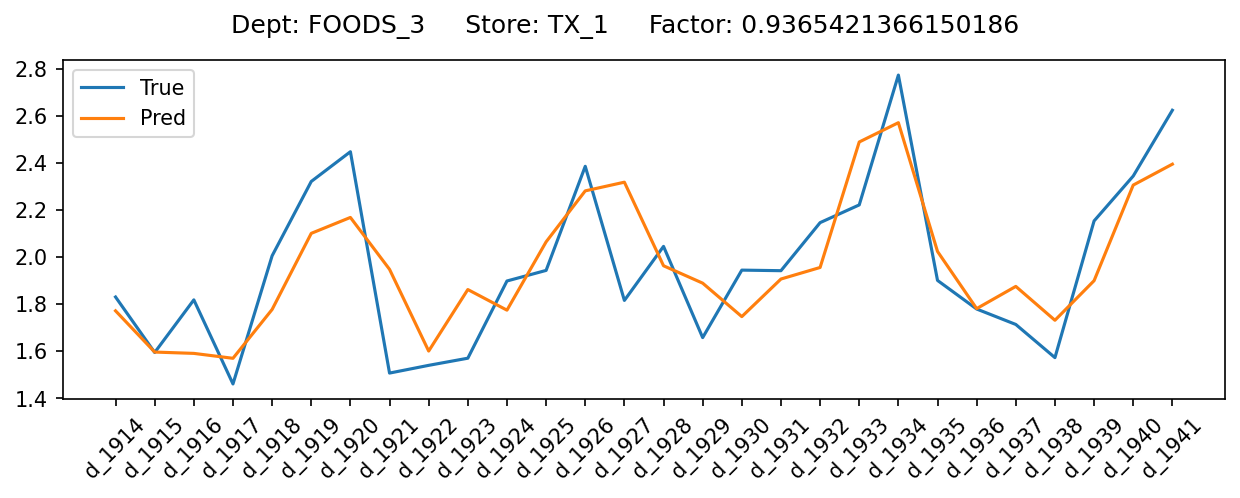

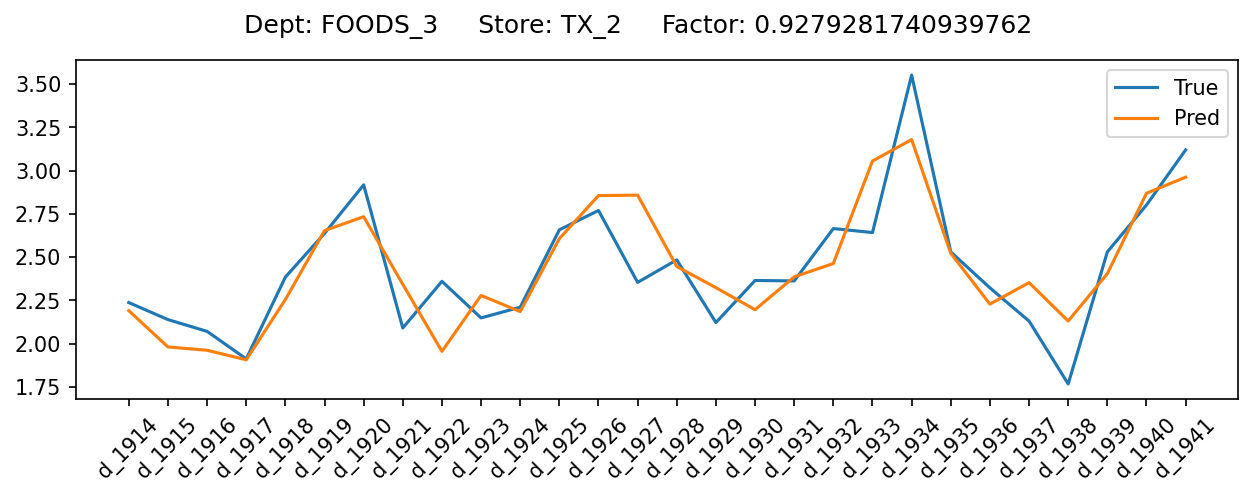

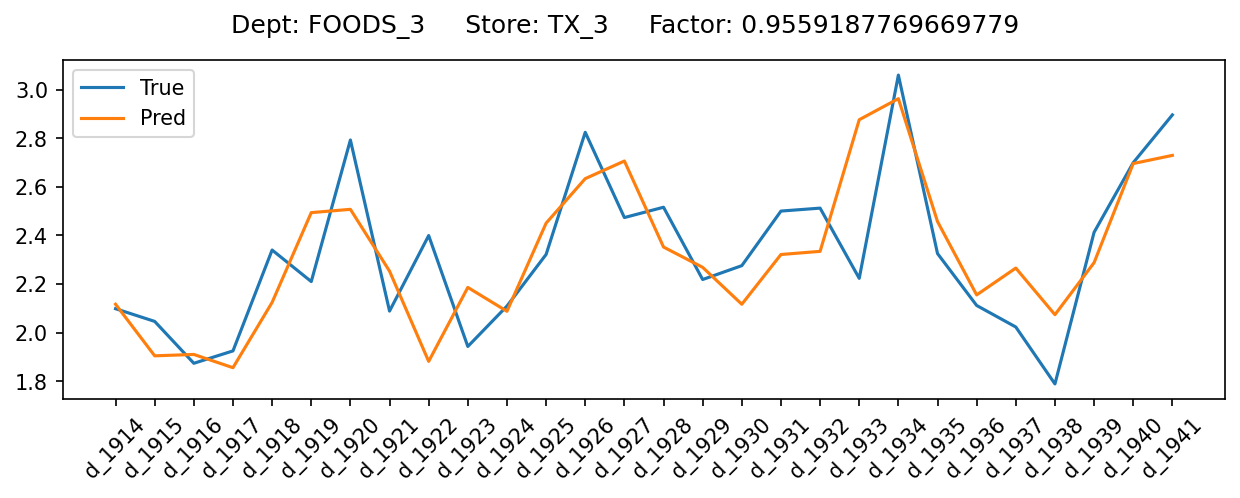

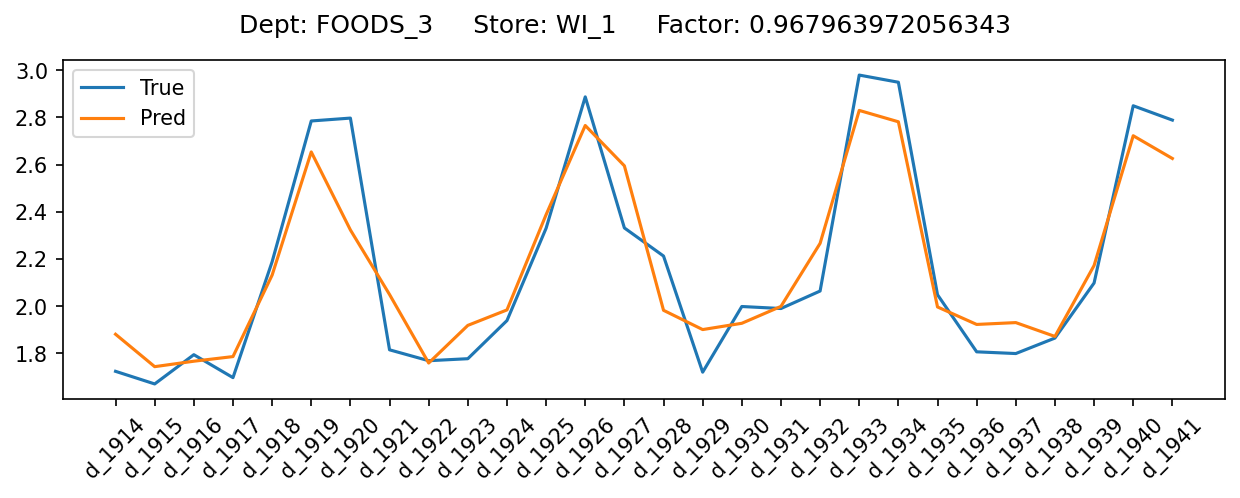

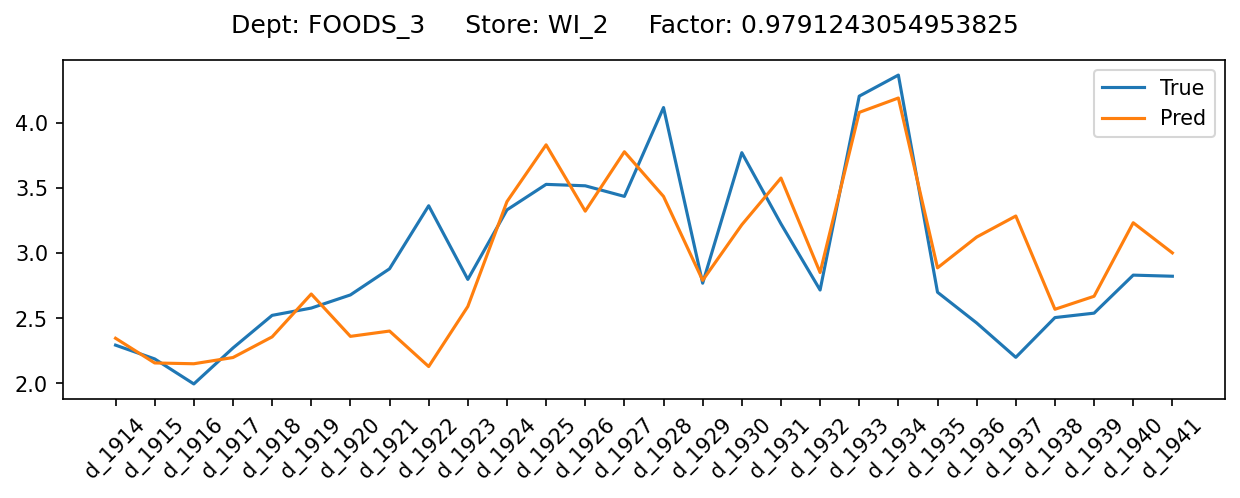

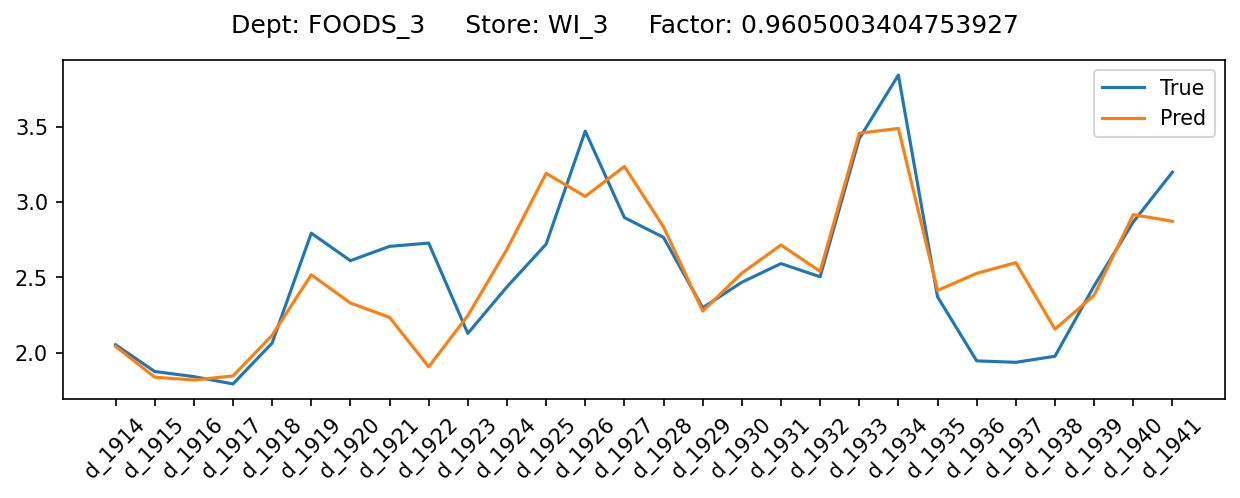

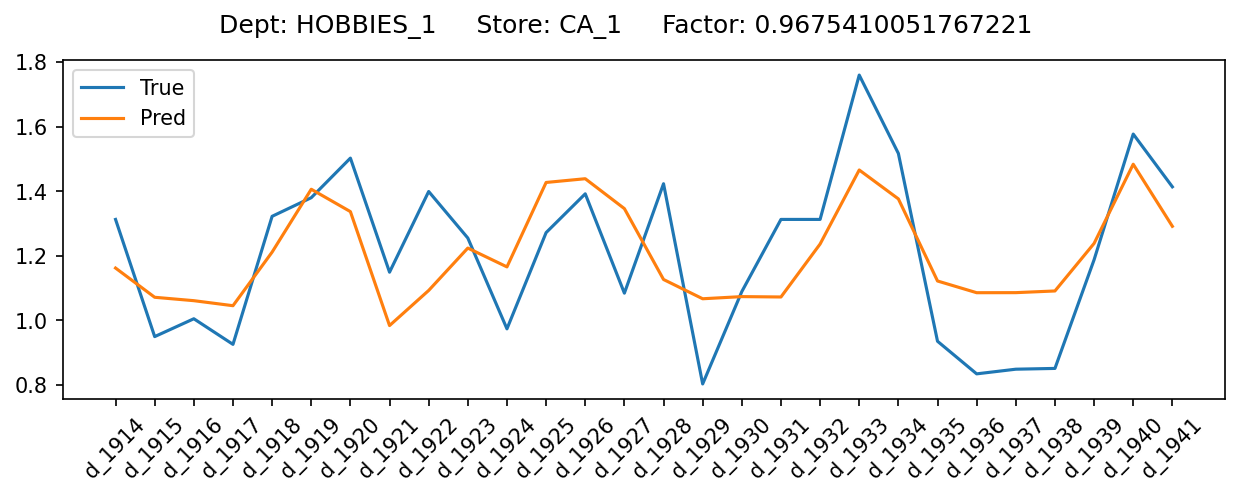

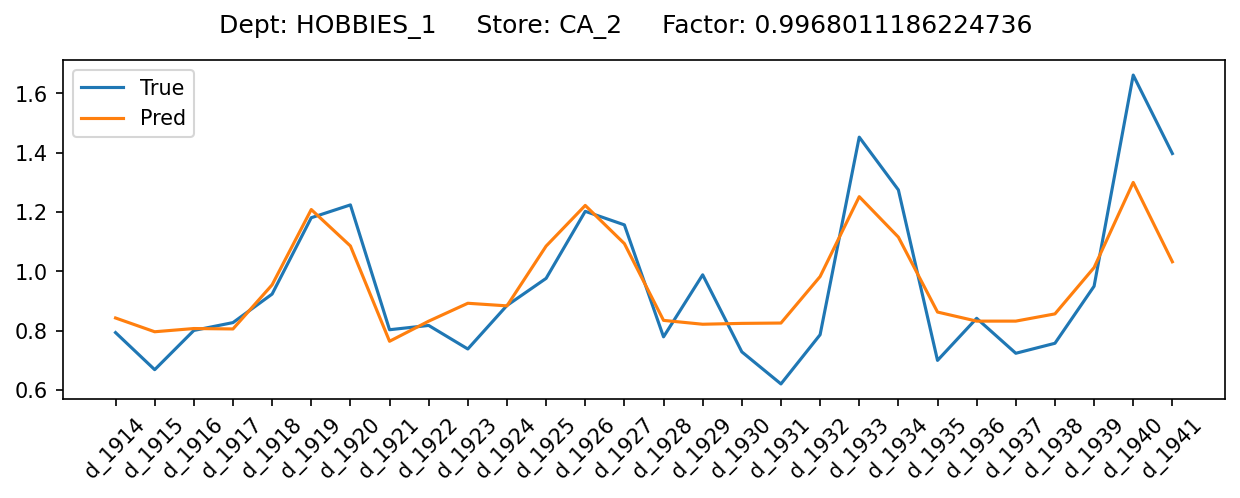

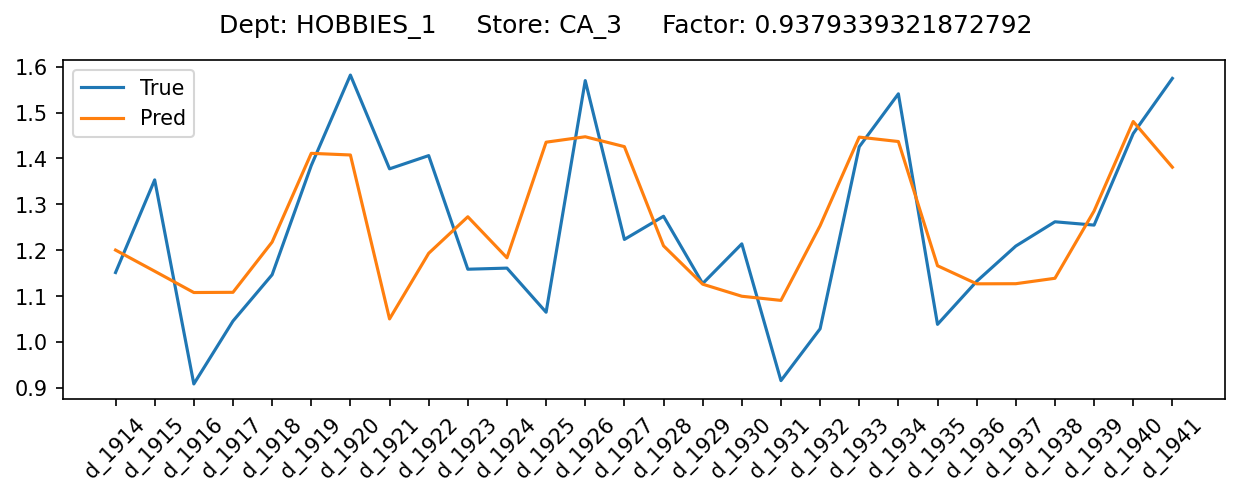

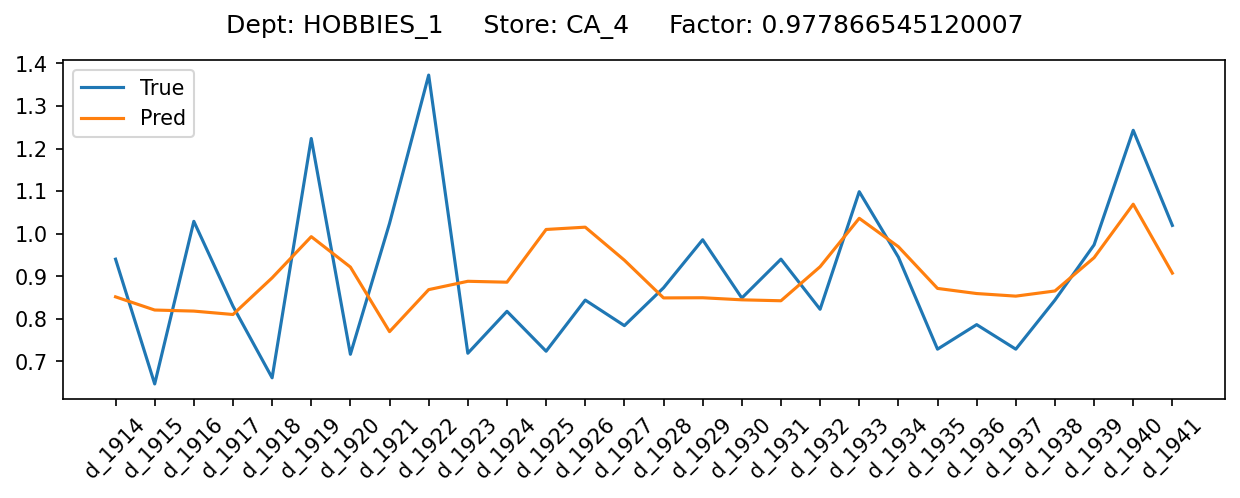

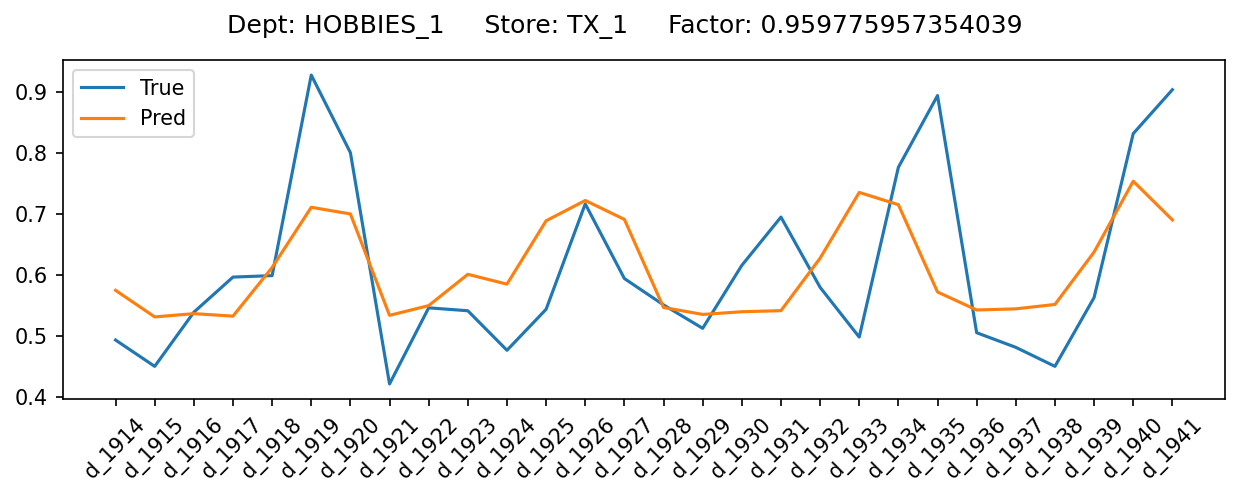

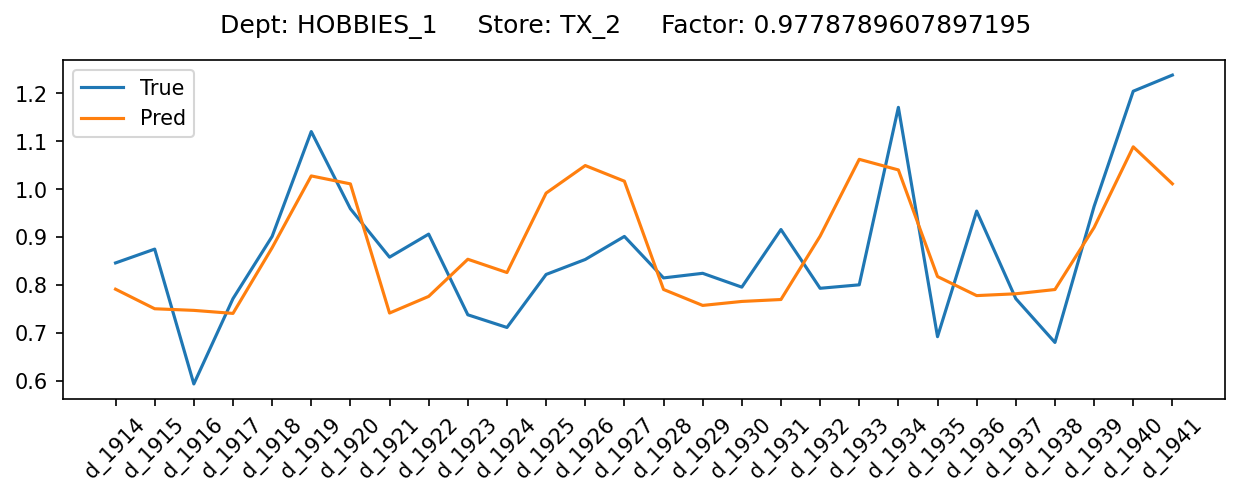

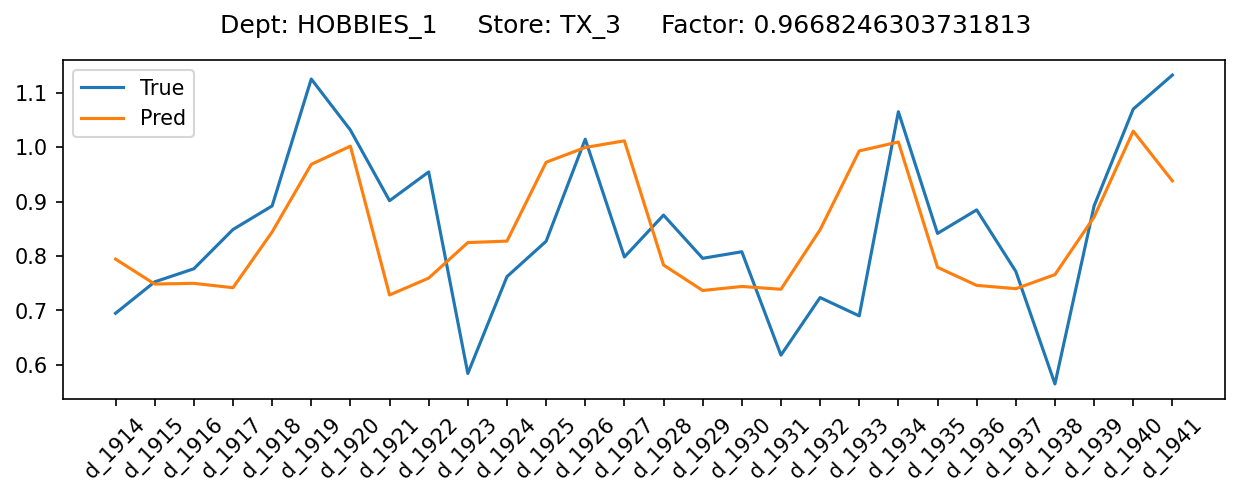

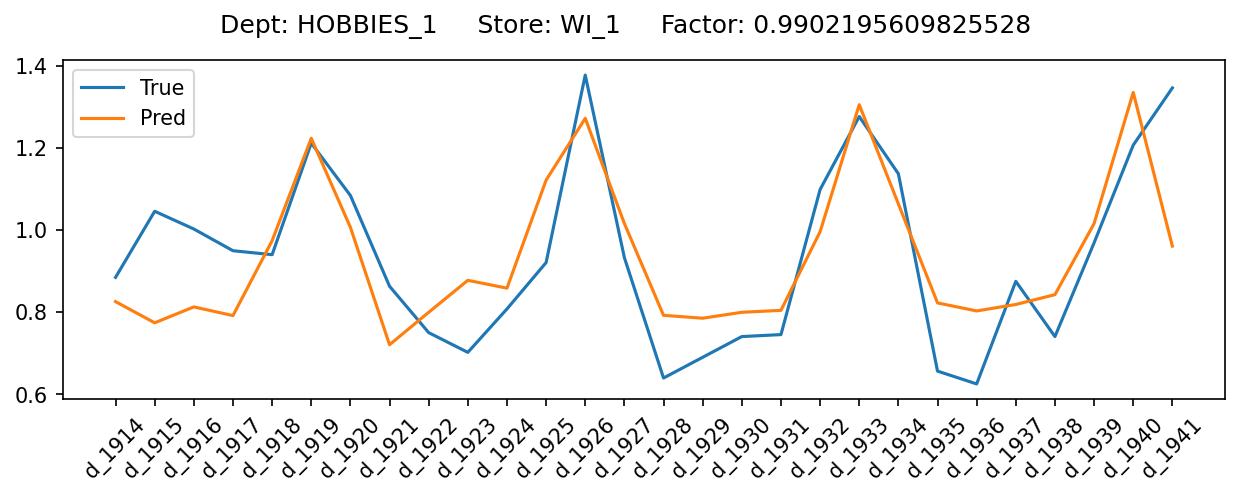

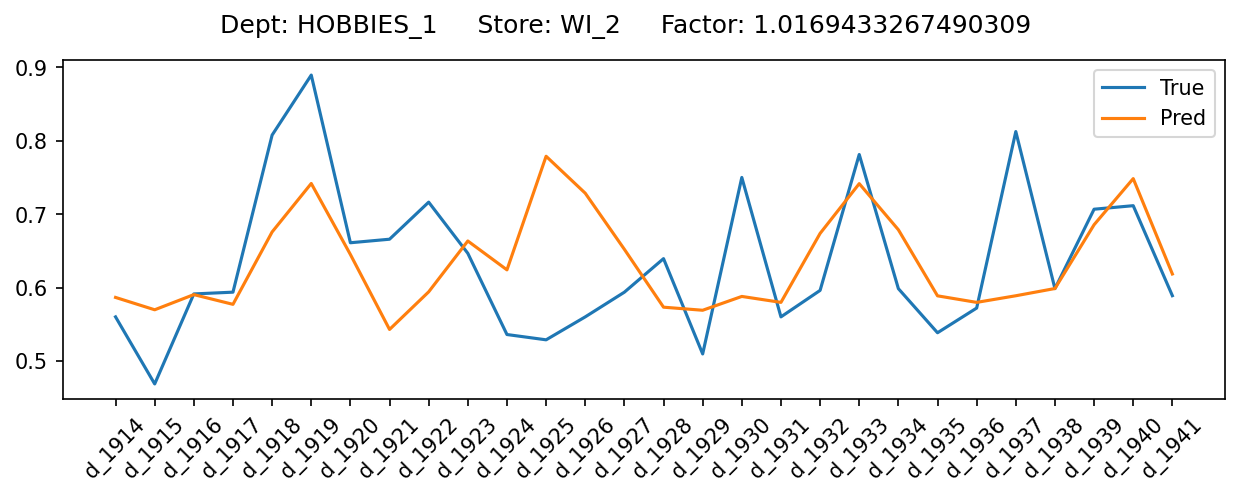

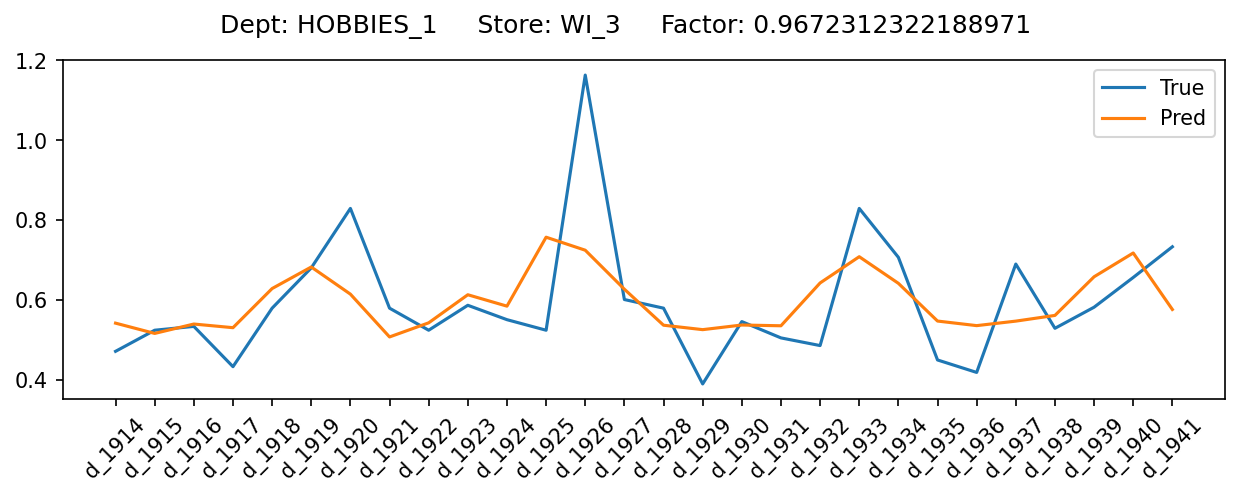

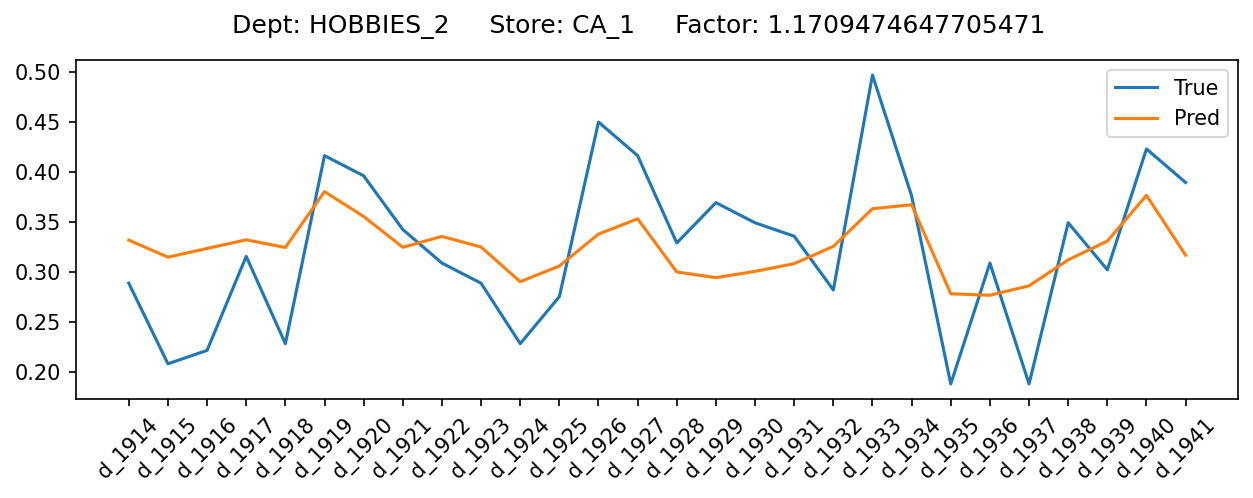

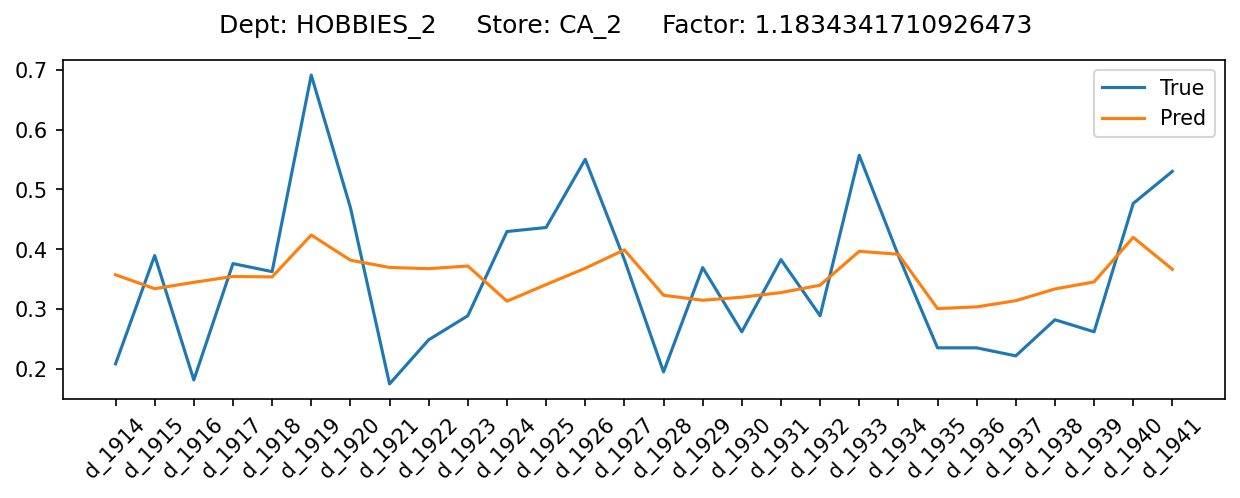

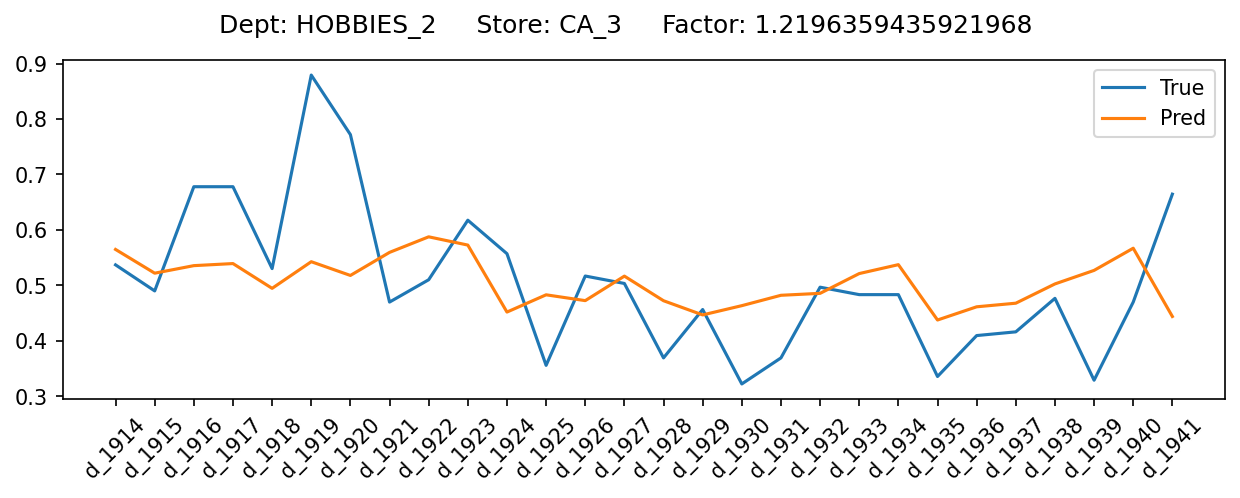

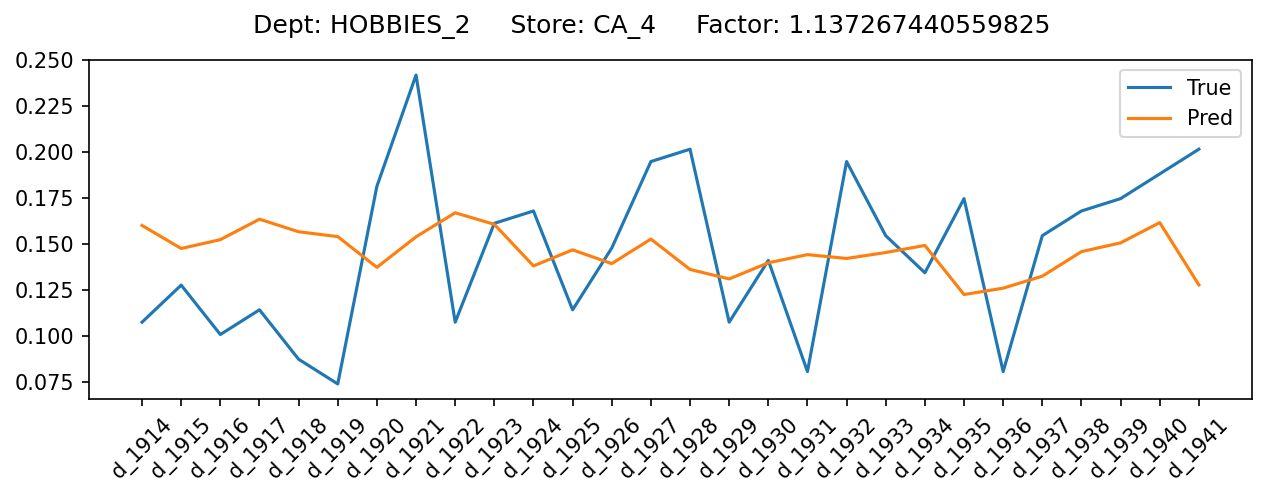

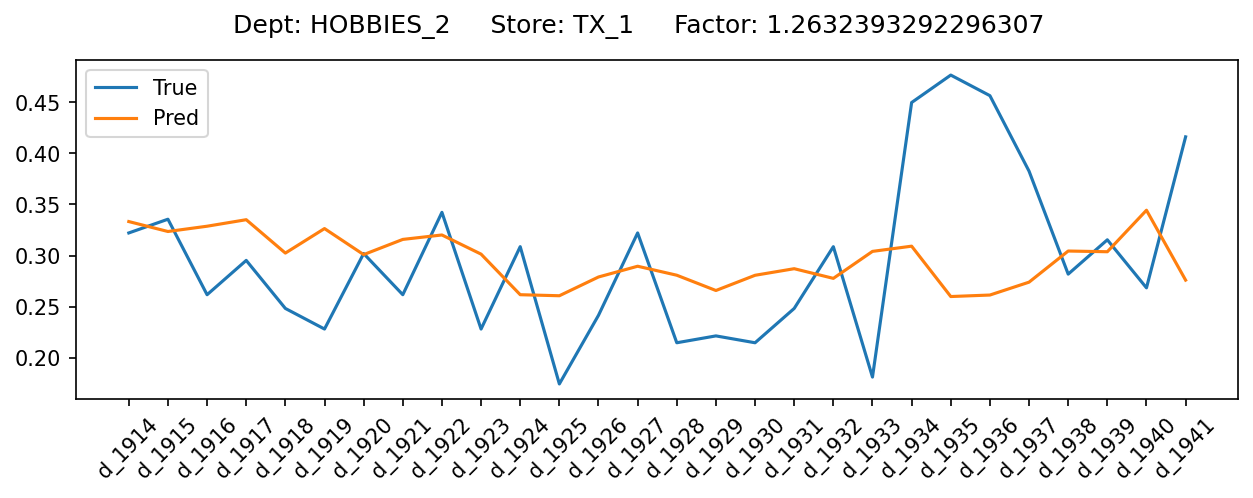

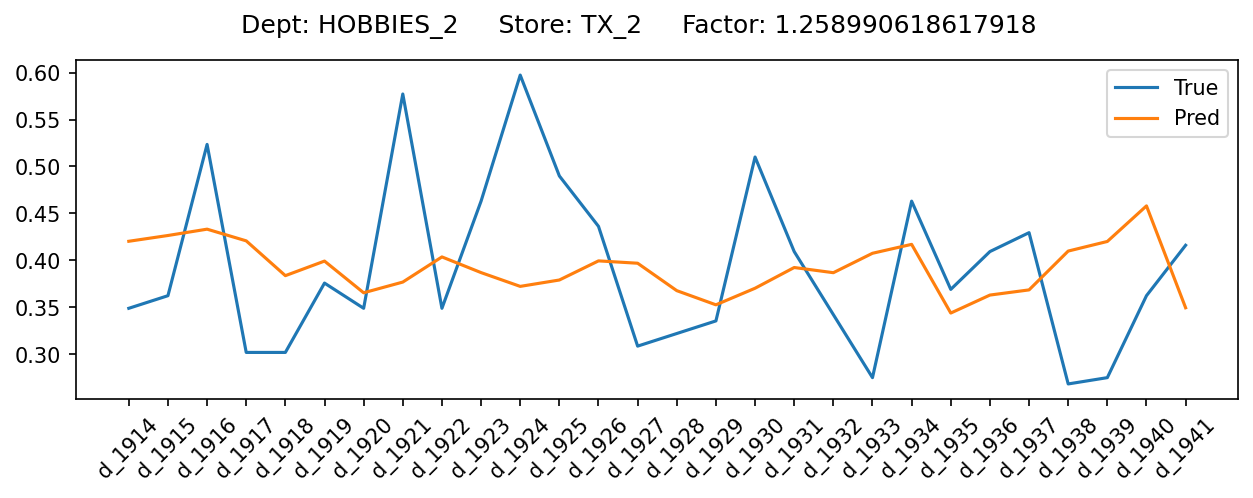

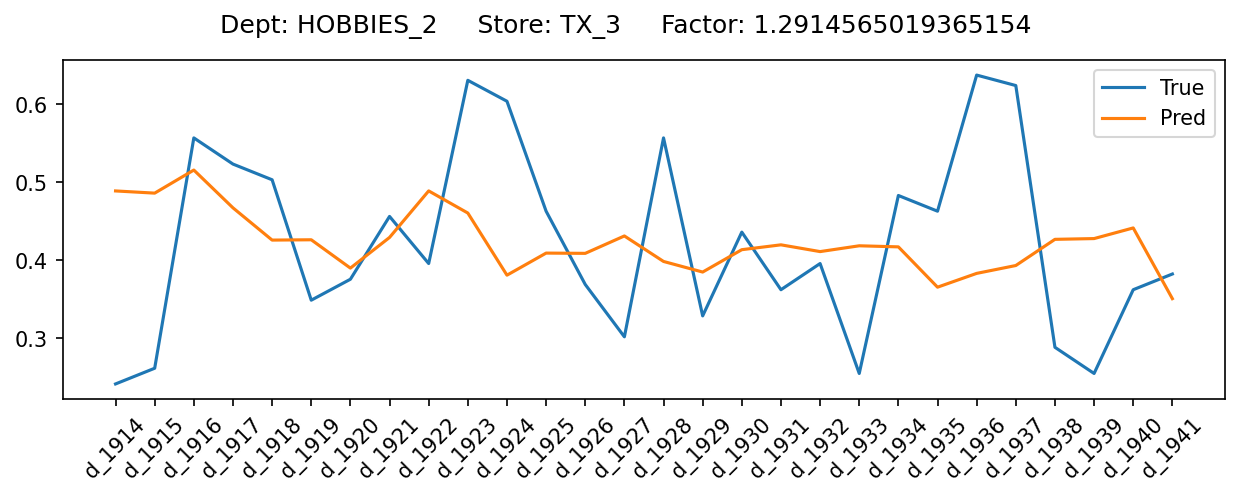

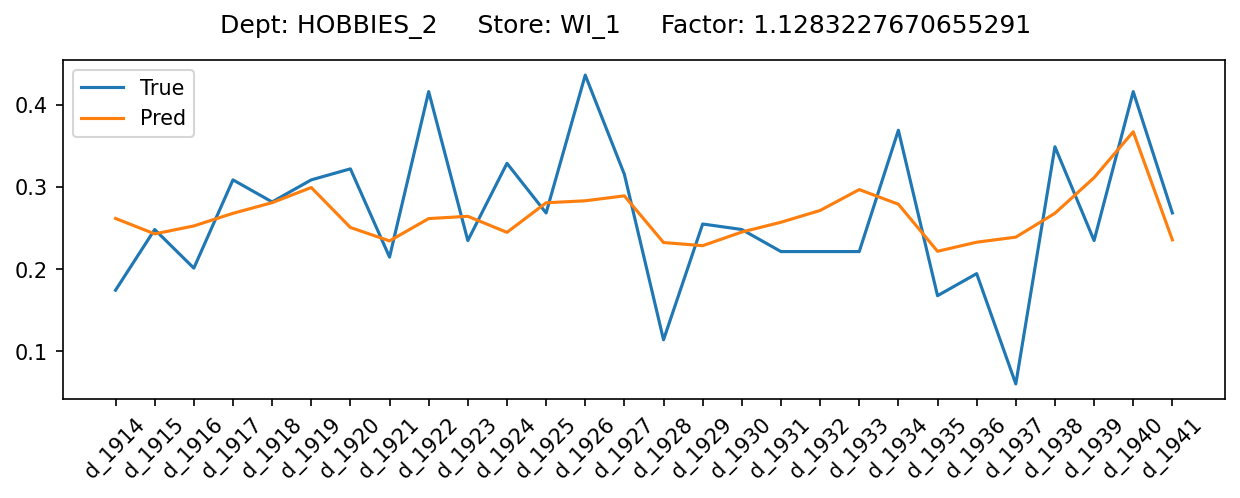

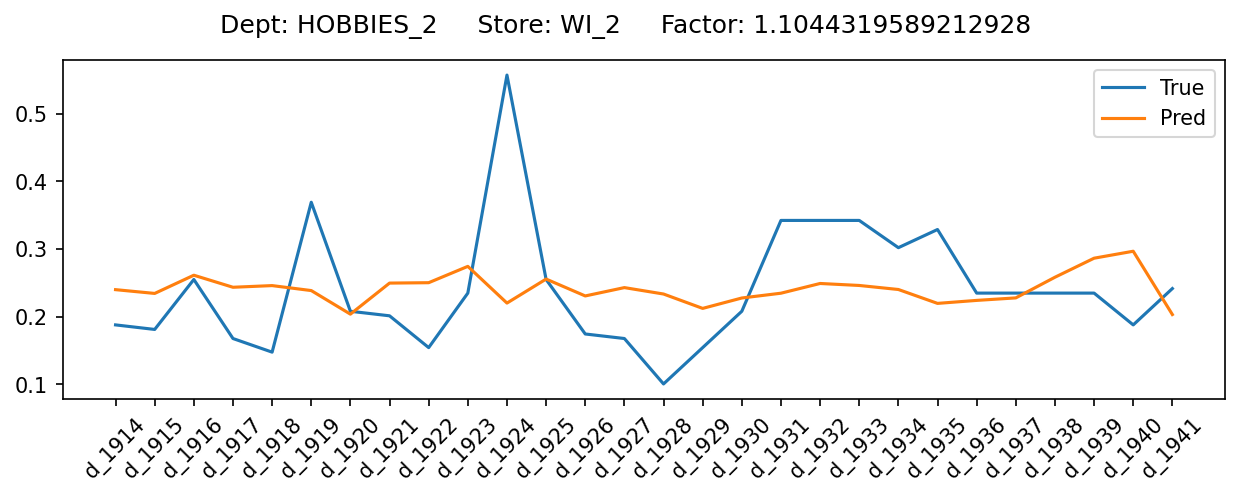

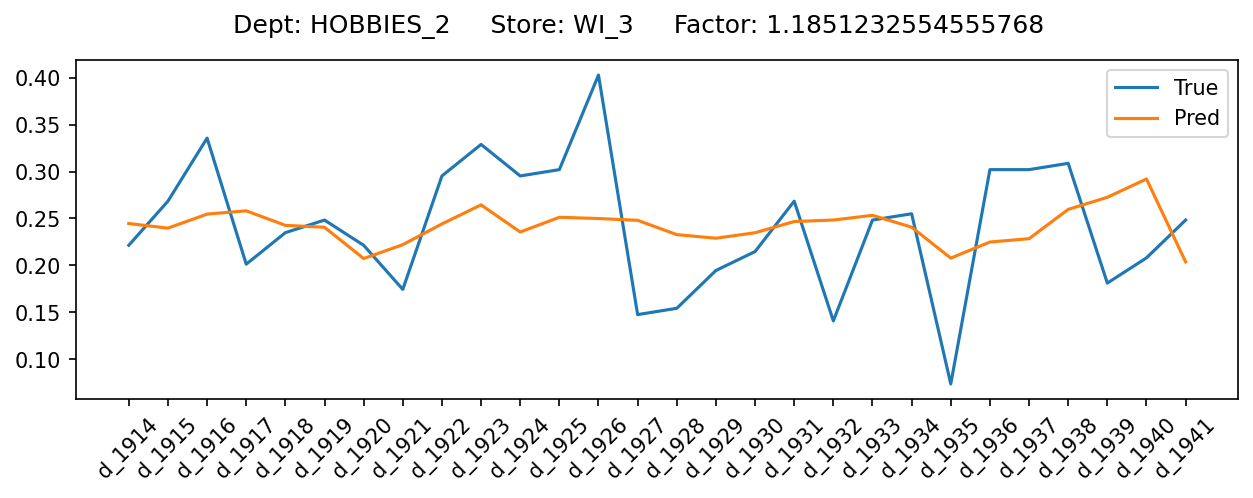

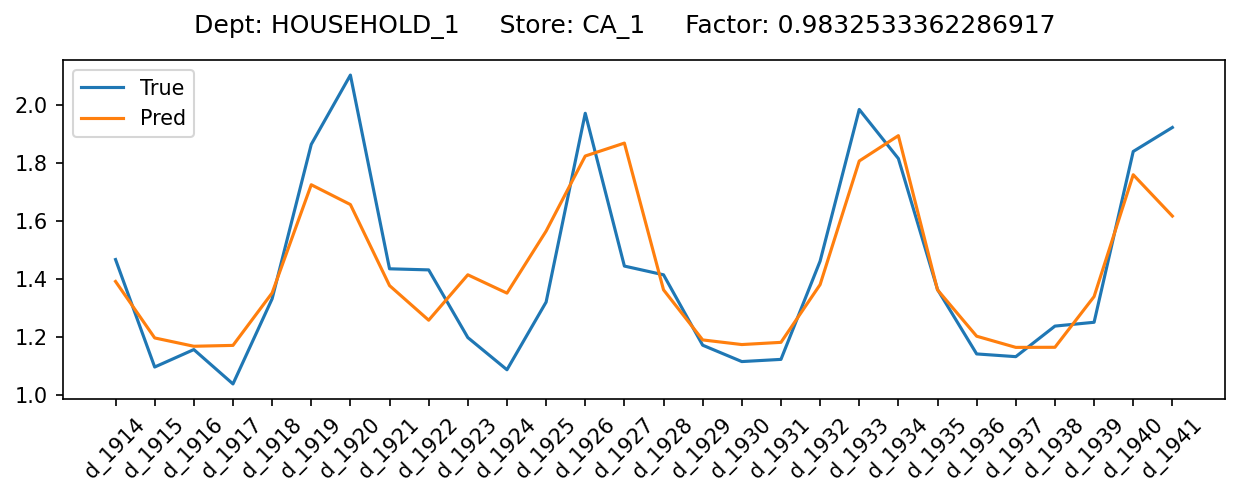

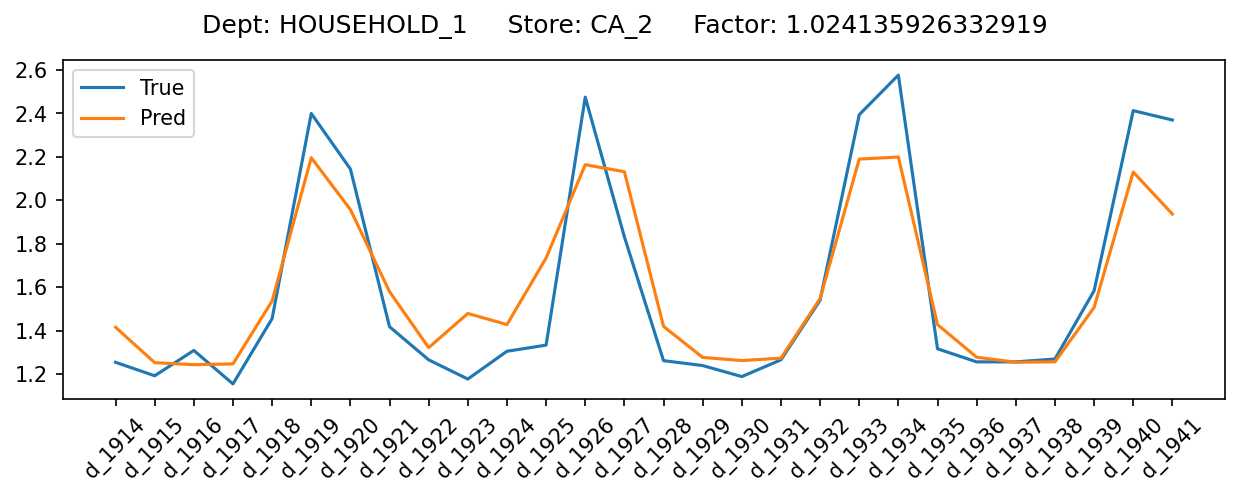

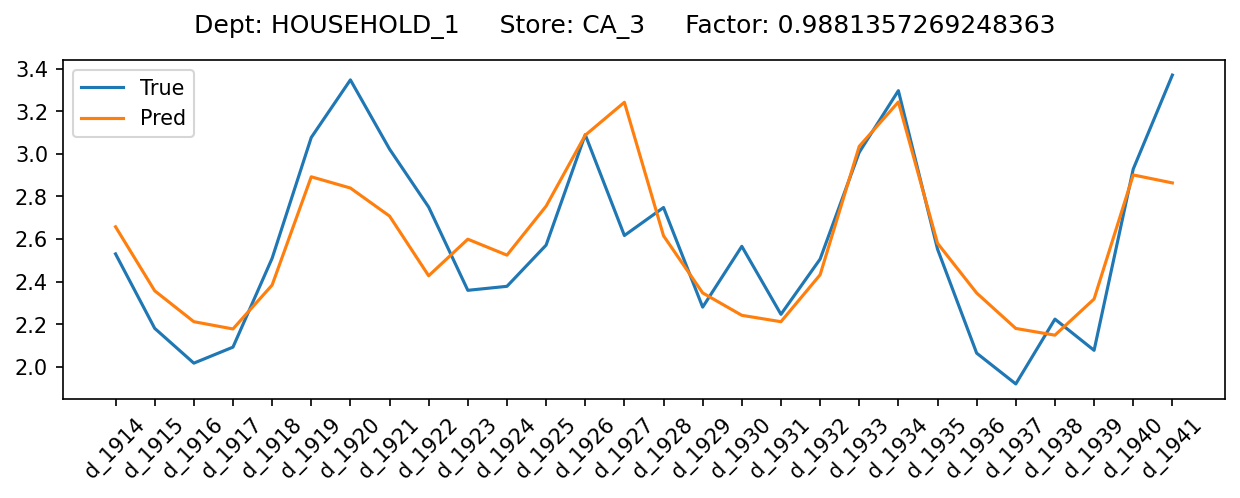

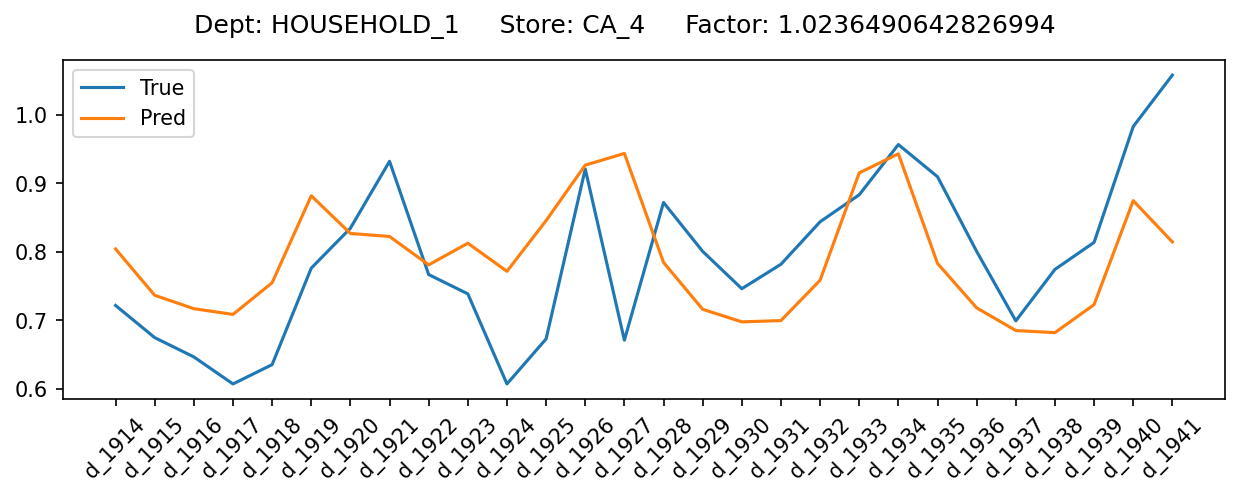

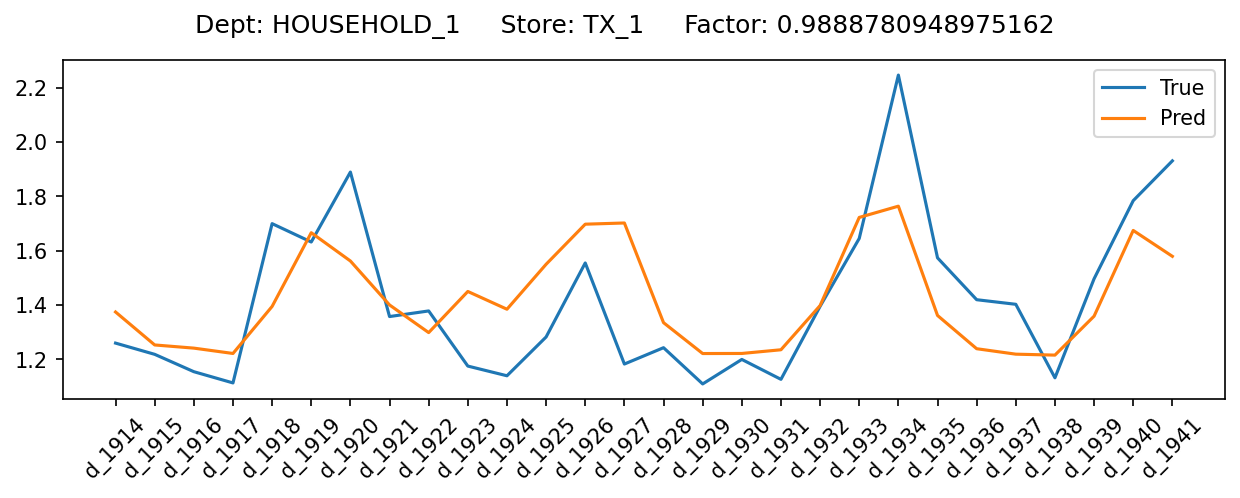

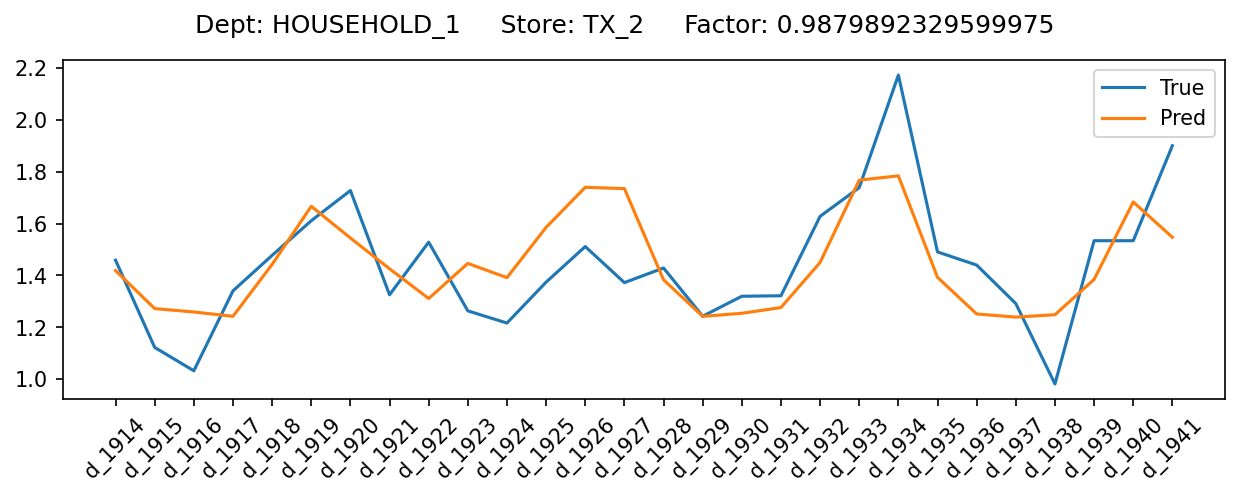

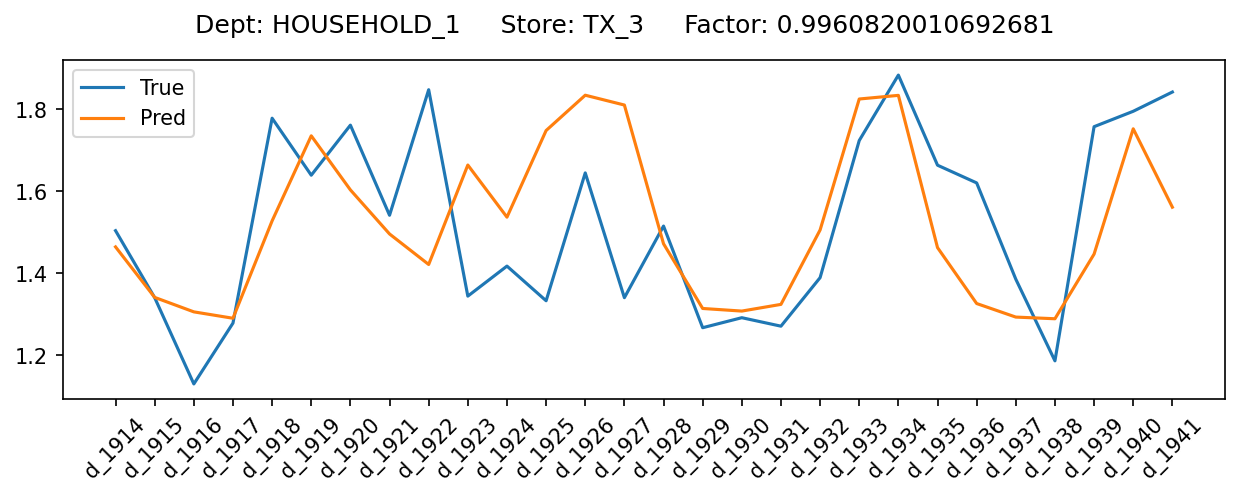

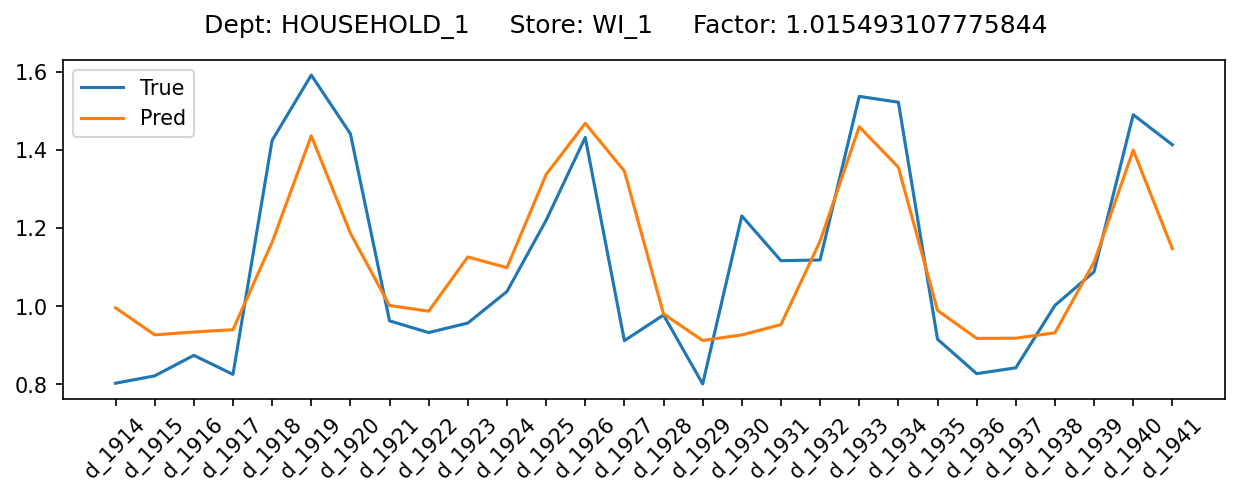

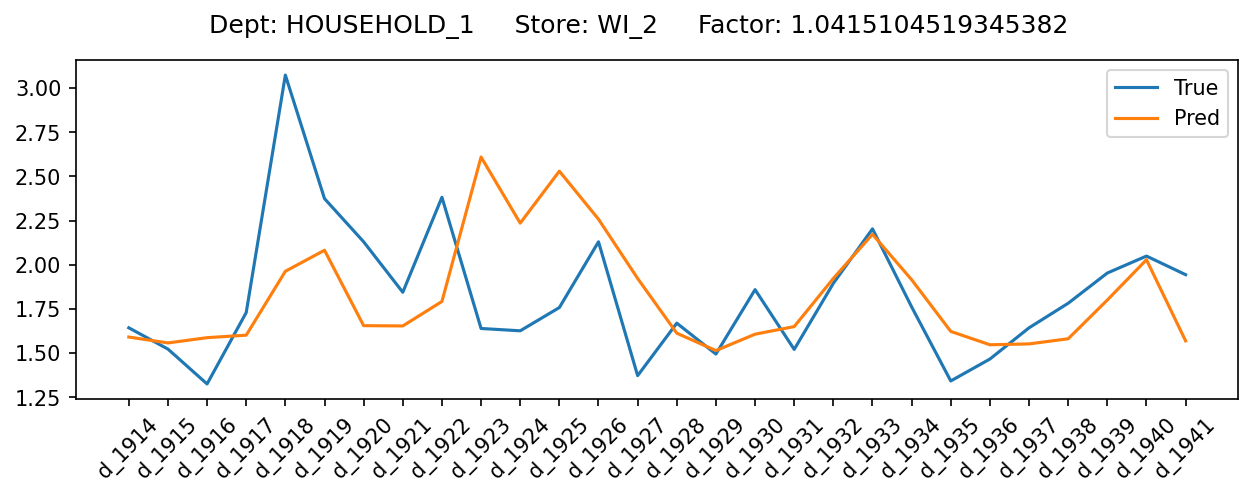

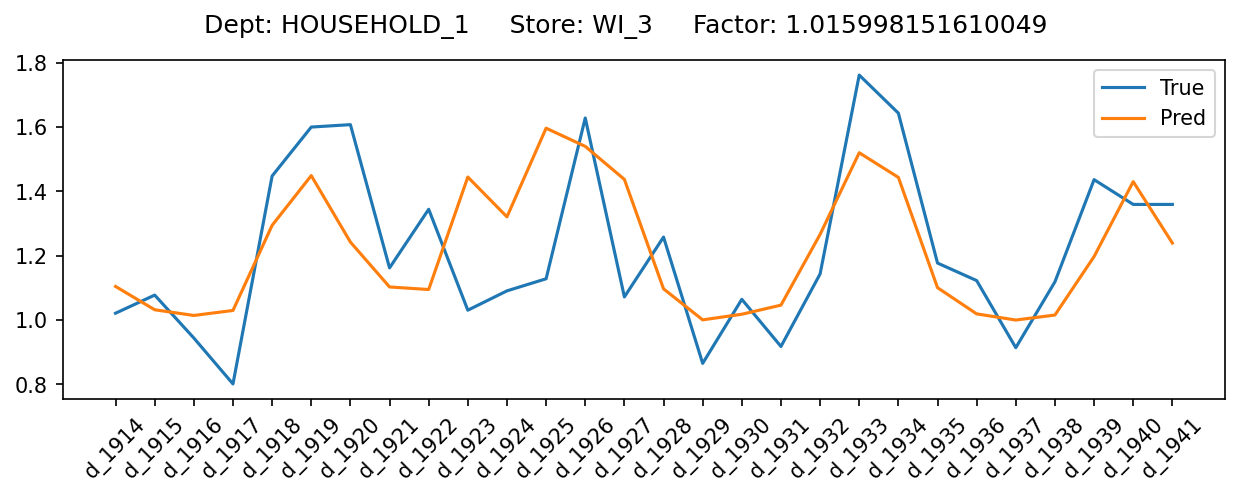

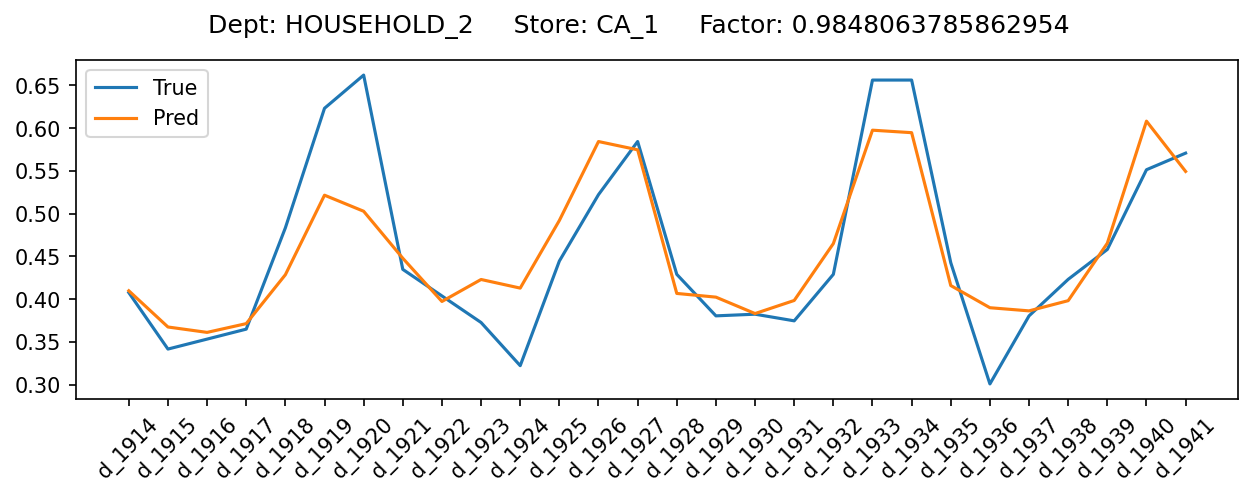

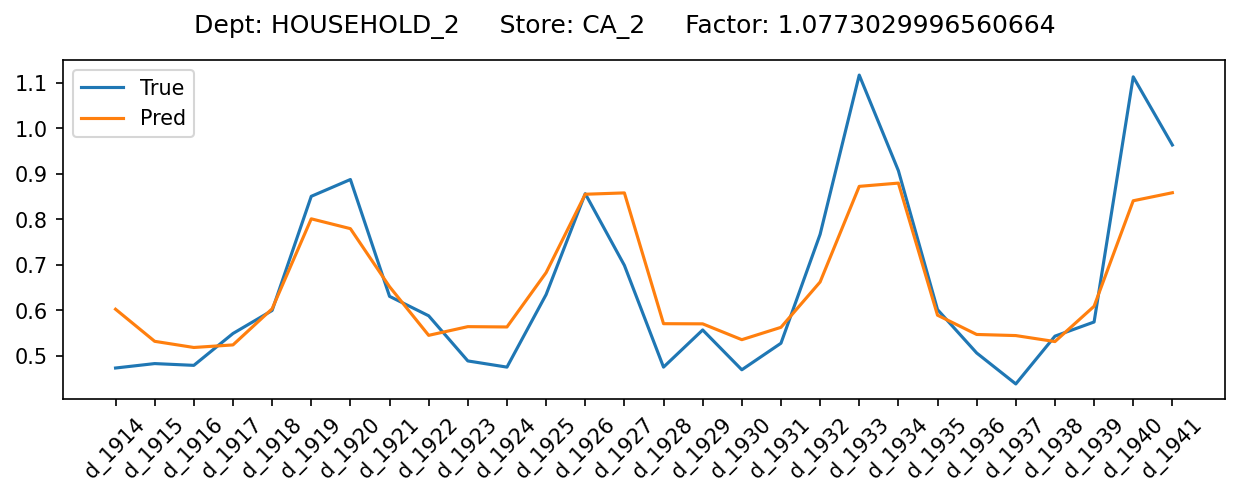

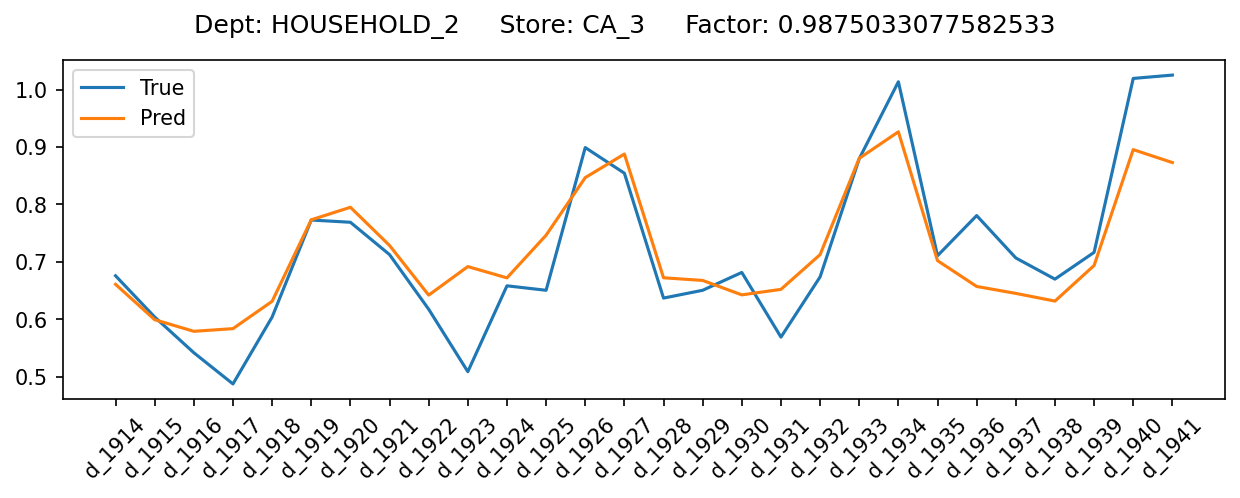

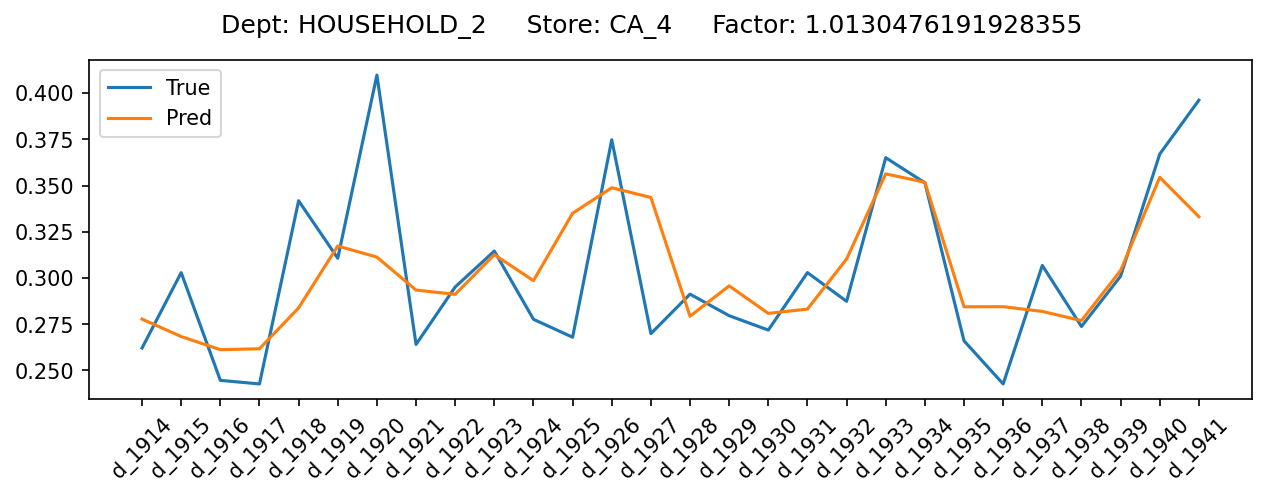

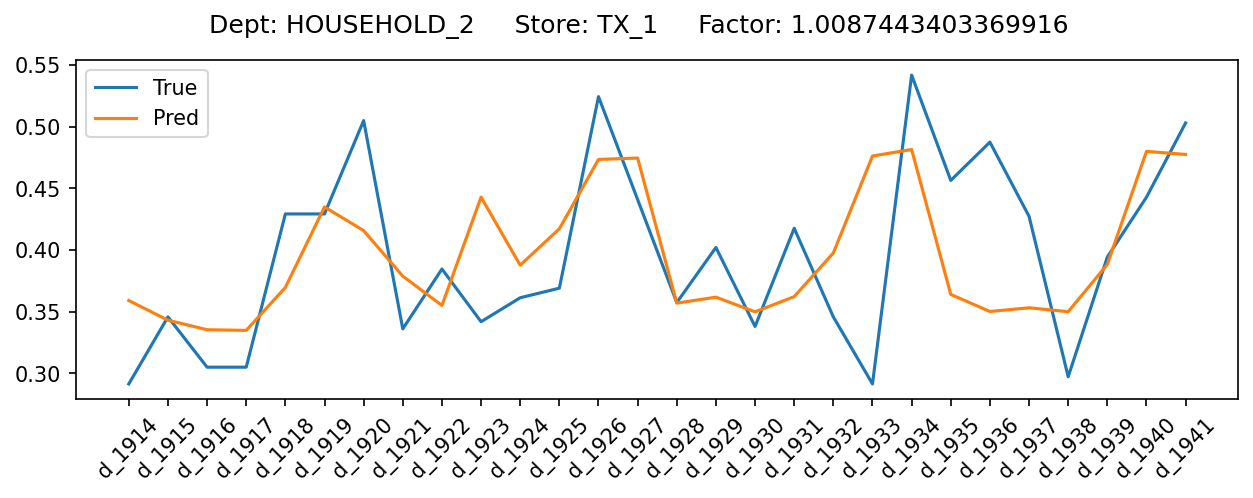

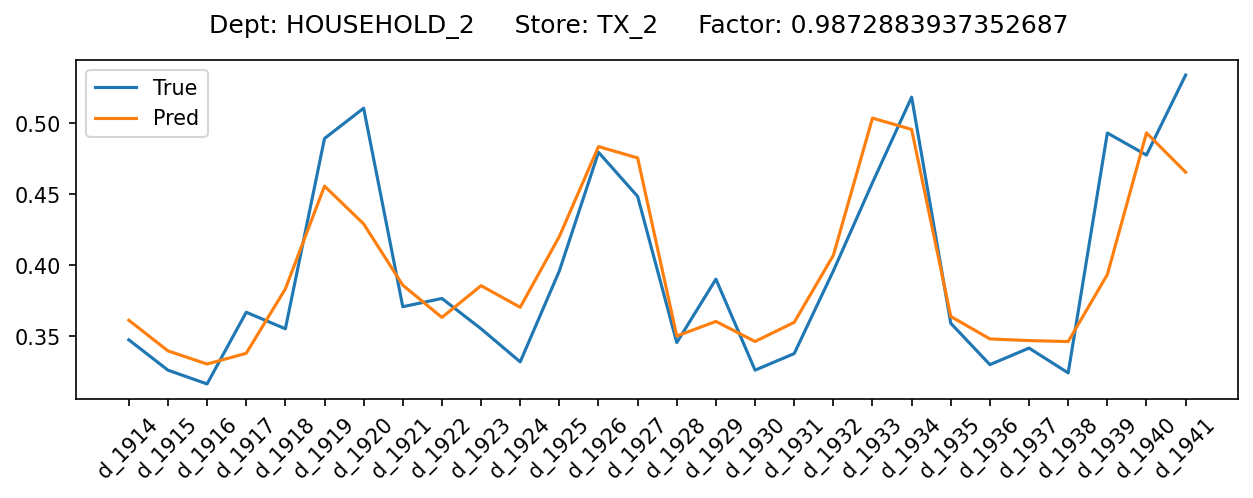

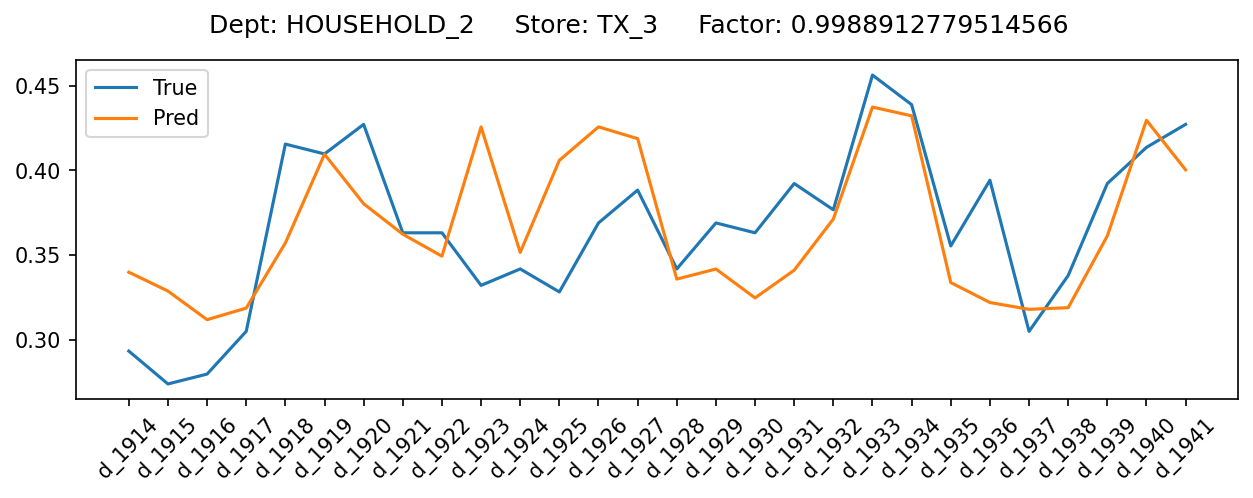

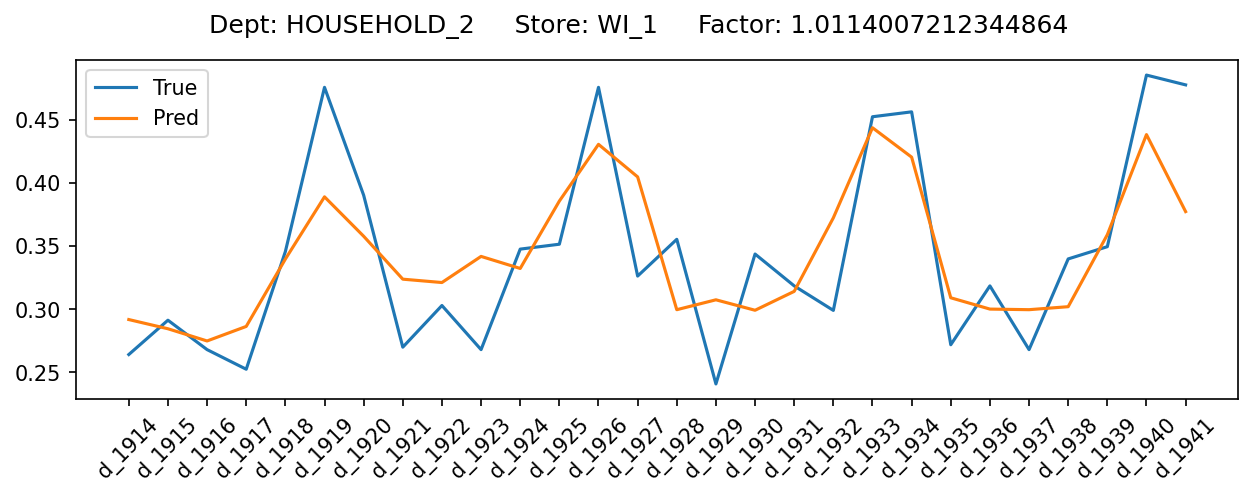

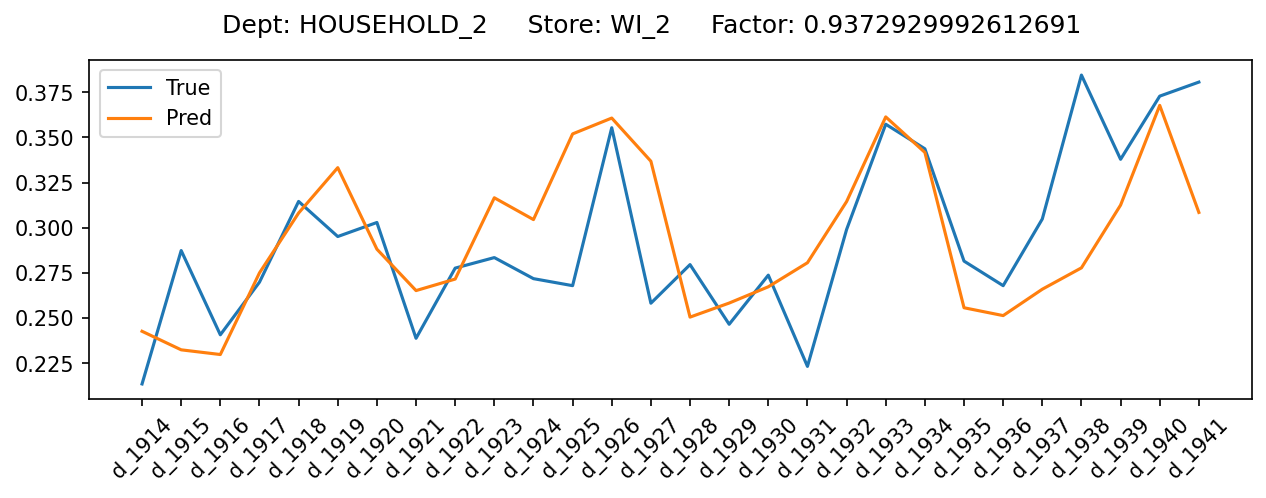

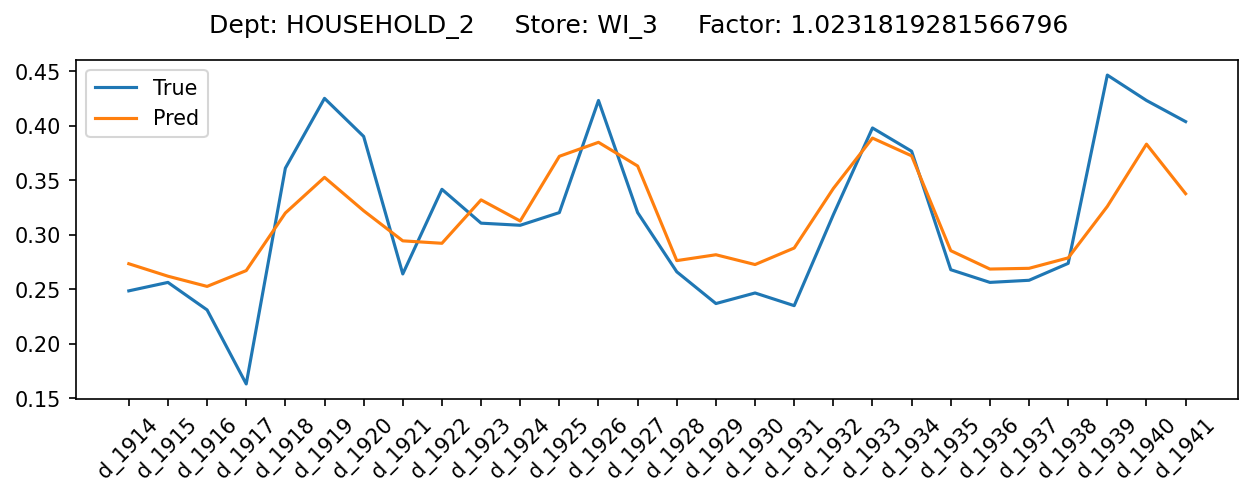

In [47]:
depts = []
stores = []
factors = []

for i in range(0, len(df_comp_mean)):

    x = df_comp_mean.iloc[i,:28].index
    y_true = df_comp_mean.iloc[i,:28].values
    y_pred = df_comp_mean.iloc[i,28:].values
    factor = y_true.mean()/y_pred.mean()
    indice = df_comp_mean.index[i]

    depts.append(indice[0])
    stores.append(indice[1])
    factors.append(factor)
    
    fig, ax = plt.subplots(figsize = (10,3), dpi=150)

    fig.suptitle('Dept: {dept}     Store: {store}     Factor: {factor}'.format(
        dept=indice[0], store=indice[1], factor=factor))
    ax.plot(x, y_true, label='True')
    ax.plot(x, y_pred*factor, label='Pred')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

    plt.show()
    
df_factors = pd.DataFrame(data={'dept_id':depts, 'store_id':stores, 'factor':factors})


In [48]:
df_factors

dept_id store_id    factor
0       FOODS_1     CA_1  0.922502
1       FOODS_1     CA_2  0.974244
2       FOODS_1     CA_3  0.987526
3       FOODS_1     CA_4  0.982441
4       FOODS_1     TX_1  0.971888
5       FOODS_1     TX_2  1.009676
6       FOODS_1     TX_3  1.067395
7       FOODS_1     WI_1  1.002122
8       FOODS_1     WI_2  1.065574
9       FOODS_1     WI_3  1.084851
10      FOODS_2     CA_1  1.005784
11      FOODS_2     CA_2  1.034435
12      FOODS_2     CA_3  1.009569
13      FOODS_2     CA_4  1.034246
14      FOODS_2     TX_1  0.945916
15      FOODS_2     TX_2  0.941809
16      FOODS_2     TX_3  0.969702
17      FOODS_2     WI_1  1.063325
18      FOODS_2     WI_2  1.058929
19      FOODS_2     WI_3  1.075088
20      FOODS_3     CA_1  0.948605
21      FOODS_3     CA_2  0.973528
22      FOODS_3     CA_3  0.898816
23      FOODS_3     CA_4  0.951665
24      FOODS_3     TX_1  0.936542
25      FOODS_3     TX_2  0.927928
26      FOODS_3     TX_3  0.955919
27      FOODS_3     WI_1  0.967964
28      FOODS_3     WI_2  0.979124
29      FOODS_3     WI_3  0.960500
30    HOBBIES_1     CA_1  0.967541
31    HOBBIES_1     CA_2  0.996801
32    HOBBIES_1     CA_3  0.937934
33    HOBBIES_1     CA_4  0.977867
34    HOBBIES_1     TX_1  0.959776
35    HOBBIES_1     TX_2  0.977879
36    HOBBIES_1     TX_3  0.966825
37    HOBBIES_1     WI_1  0.990220
38    HOBBIES_1     WI_2  1.016943
39    HOBBIES_1     WI_3  0.967231
40    HOBBIES_2     CA_1  1.170947
41    HOBBIES_2     CA_2  1.183434
42    HOBBIES_2     CA_3  1.219636
43    HOBBIES_2     CA_4  1.137267
44    HOBBIES_2     TX_1  1.263239
45    HOBBIES_2     TX_2  1.258991
46    HOBBIES_2     TX_3  1.291457
47    HOBBIES_2     WI_1  1.128323
48    HOBBIES_2     WI_2  1.104432
49    HOBBIES_2     WI_3  1.185123
50  HOUSEHOLD_1     CA_1  0.983253
51  HOUSEHOLD_1     CA_2  1.024136
52  HOUSEHOLD_1     CA_3  0.988136
53  HOUSEHOLD_1     CA_4  1.023649
54  HOUSEHOLD_1     TX_1  0.988878
55  HOUSEHOLD_1     TX_2  0.987989
56  HOUSEHOLD_1     TX_3  0.996082
57  HOUSEHOLD_1     WI_1  1.015493
58  HOUSEHOLD_1     WI_2  1.041510
59  HOUSEHOLD_1     WI_3  1.015998
60  HOUSEHOLD_2     CA_1  0.984806
61  HOUSEHOLD_2     CA_2  1.077303
62  HOUSEHOLD_2     CA_3  0.987503
63  HOUSEHOLD_2     CA_4  1.013048
64  HOUSEHOLD_2     TX_1  1.008744
65  HOUSEHOLD_2     TX_2  0.987288
66  HOUSEHOLD_2     TX_3  0.998891
67  HOUSEHOLD_2     WI_1  1.011401
68  HOUSEHOLD_2     WI_2  0.937293
69  HOUSEHOLD_2     WI_3  1.023182

In [49]:
df_factors.to_csv('./proc_data/factor.csv', index=False)

## Create Submission file

In [50]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

In [51]:
sub = pd.read_csv('./proc_data/partial_submission.csv')
factors = pd.read_csv('./proc_data/factor.csv')
df_ids = pd.read_csv('./raw_data/sales_train_evaluation.csv', usecols=['id','dept_id','store_id']).drop_duplicates()

In [52]:
sub = sub.drop_duplicates()

In [53]:
factors = df_ids.merge(factors, on=['dept_id','store_id']).drop(['dept_id','store_id'], axis=1)
sub = sub.merge(factors, on='id', how='inner')

In [54]:
cols_f = ['F{}'.format(c) for c in range(1, 29)]
for c in cols_f:
    sub[c] = sub[c]*sub['factor']
    
sub = sub[['id']+cols_f]

In [55]:
sub

id        F1        F2        F3        F4  \
0      HOBBIES_1_001_CA_1_evaluation  0.862936  0.857806  0.849181  0.885436   
1      HOBBIES_1_002_CA_1_evaluation  0.231947  0.231251  0.213385  0.213471   
2      HOBBIES_1_003_CA_1_evaluation  0.428214  0.422008  0.428237  0.443813   
3      HOBBIES_1_004_CA_1_evaluation  1.828175  1.453222  1.503811  1.584352   
4      HOBBIES_1_005_CA_1_evaluation  1.351026  1.219605  1.193044  1.117859   
...                              ...       ...       ...       ...       ...   
30485    FOODS_3_823_WI_3_evaluation  0.457662  0.450988  0.462633  0.427989   
30486    FOODS_3_824_WI_3_evaluation  0.155981  0.148266  0.145478  0.324286   
30487    FOODS_3_825_WI_3_evaluation  0.679682  0.545021  0.548078  0.534183   
30488    FOODS_3_826_WI_3_evaluation  1.113050  1.293990  1.010133  1.063124   
30489    FOODS_3_827_WI_3_evaluation  1.047123  1.057839  0.884732  1.157179   

             F5        F6        F7        F8        F9       F10       F11  \
0      0.987013  1.184302  1.126020  0.791076  0.791281  0.868264  0.832382   
1      0.273627  0.305018  0.278514  0.188212  0.167586  0.226506  0.193471   
2      0.620894  0.681486  0.706397  0.465633  0.487087  0.553111  0.526282   
3      1.738696  2.095574  2.304709  2.057147  1.594577  1.806737  1.852413   
4      1.351396  1.600917  1.466130  1.007845  1.102830  1.237922  1.223432   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.427857  0.551905  0.513802  0.490455  0.452317  0.527200  0.660436   
30486  0.300880  0.336224  0.280011  0.390641  0.337201  0.378947  0.440187   
30487  0.615588  0.695108  0.699005  0.711218  0.604293  0.730323  0.878081   
30488  1.143702  1.318151  1.052271  1.073575  0.969023  1.166604  1.349880   
30489  1.355837  1.473703  1.172955  1.059698  0.937403  1.025604  1.342256   

            F12       F13       F14       F15       F16       F17       F18  \
0      0.986239  1.173579  1.106728  0.866020  0.876002  0.887076  0.841492   
1      0.262738  0.342011  0.323002  0.220455  0.212718  0.201887  0.218909   
2      0.610323  0.736421  0.663962  0.453274  0.471770  0.458058  0.483588   
3      2.143699  2.281516  2.194956  1.598509  1.582696  1.632518  1.634058   
4      1.493493  1.624591  1.578052  1.149388  1.031719  1.050328  0.987051   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.659876  0.649648  0.805696  0.731302  0.538991  0.626073  0.702563   
30486  0.547934  0.415901  0.527037  0.524418  0.366220  0.400330  0.366352   
30487  1.027581  0.942821  1.137086  0.995725  0.759180  0.831548  0.877561   
30488  1.482129  1.381821  1.581117  1.446353  1.138009  1.293820  1.317221   
30489  1.639337  1.618198  1.779350  1.441878  1.170713  1.261688  1.258476   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.939138  1.147442  1.144395  0.906676  0.838586  0.838090  0.826951   
1      0.276880  0.345580  0.358974  0.248569  0.239834  0.226980  0.228303   
2      0.541347  0.714809  0.714021  0.492651  0.471429  0.472289  0.491178   
3      1.910221  2.385584  2.413602  1.788931  1.619740  1.650799  1.662601   
4      1.195445  1.474733  1.477458  1.115715  1.043700  1.053128  1.042185   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.583551  0.807108  0.906700  0.696223  0.682902  0.664033  0.587482   
30486  0.318490  0.419744  0.466141  0.366532  0.413135  0.421989  0.360654   
30487  0.728282  1.120815  1.174049  0.844361  0.824749  0.819792  0.615355   
30488  1.246492  1.640806  1.675307  1.391423  1.473976  1.430512  1.192960   
30489  1.268727  1.670846  1.501722  1.150417  1.145644  1.114485  0.983247   

            F26       F27       F28  
0      0.864157  1.138188  1.061731  
1      0.296688  0.374113  0.288286  
2      0.527976  0.636246  0.582619  
3      1.921375  2.389312  2.734758  
4      1.187298  1.507134  1.293361 

In [56]:
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("evaluation","validation")
sub = pd.concat([sub2, sub], axis=0, sort=False)
sub.columns = ['id'] + ['F' + str(c) for c in np.arange(1,29,1)]

In [57]:
sub.to_csv('./output_data/submission.csv', index=False)

In [58]:
sub

id        F1        F2        F3        F4  \
0      HOBBIES_1_001_CA_1_validation  0.862936  0.857806  0.849181  0.885436   
1      HOBBIES_1_002_CA_1_validation  0.231947  0.231251  0.213385  0.213471   
2      HOBBIES_1_003_CA_1_validation  0.428214  0.422008  0.428237  0.443813   
3      HOBBIES_1_004_CA_1_validation  1.828175  1.453222  1.503811  1.584352   
4      HOBBIES_1_005_CA_1_validation  1.351026  1.219605  1.193044  1.117859   
...                              ...       ...       ...       ...       ...   
30485    FOODS_3_823_WI_3_evaluation  0.457662  0.450988  0.462633  0.427989   
30486    FOODS_3_824_WI_3_evaluation  0.155981  0.148266  0.145478  0.324286   
30487    FOODS_3_825_WI_3_evaluation  0.679682  0.545021  0.548078  0.534183   
30488    FOODS_3_826_WI_3_evaluation  1.113050  1.293990  1.010133  1.063124   
30489    FOODS_3_827_WI_3_evaluation  1.047123  1.057839  0.884732  1.157179   

             F5        F6        F7        F8        F9       F10       F11  \
0      0.987013  1.184302  1.126020  0.791076  0.791281  0.868264  0.832382   
1      0.273627  0.305018  0.278514  0.188212  0.167586  0.226506  0.193471   
2      0.620894  0.681486  0.706397  0.465633  0.487087  0.553111  0.526282   
3      1.738696  2.095574  2.304709  2.057147  1.594577  1.806737  1.852413   
4      1.351396  1.600917  1.466130  1.007845  1.102830  1.237922  1.223432   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.427857  0.551905  0.513802  0.490455  0.452317  0.527200  0.660436   
30486  0.300880  0.336224  0.280011  0.390641  0.337201  0.378947  0.440187   
30487  0.615588  0.695108  0.699005  0.711218  0.604293  0.730323  0.878081   
30488  1.143702  1.318151  1.052271  1.073575  0.969023  1.166604  1.349880   
30489  1.355837  1.473703  1.172955  1.059698  0.937403  1.025604  1.342256   

            F12       F13       F14       F15       F16       F17       F18  \
0      0.986239  1.173579  1.106728  0.866020  0.876002  0.887076  0.841492   
1      0.262738  0.342011  0.323002  0.220455  0.212718  0.201887  0.218909   
2      0.610323  0.736421  0.663962  0.453274  0.471770  0.458058  0.483588   
3      2.143699  2.281516  2.194956  1.598509  1.582696  1.632518  1.634058   
4      1.493493  1.624591  1.578052  1.149388  1.031719  1.050328  0.987051   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.659876  0.649648  0.805696  0.731302  0.538991  0.626073  0.702563   
30486  0.547934  0.415901  0.527037  0.524418  0.366220  0.400330  0.366352   
30487  1.027581  0.942821  1.137086  0.995725  0.759180  0.831548  0.877561   
30488  1.482129  1.381821  1.581117  1.446353  1.138009  1.293820  1.317221   
30489  1.639337  1.618198  1.779350  1.441878  1.170713  1.261688  1.258476   

            F19       F20       F21       F22       F23       F24       F25  \
0      0.939138  1.147442  1.144395  0.906676  0.838586  0.838090  0.826951   
1      0.276880  0.345580  0.358974  0.248569  0.239834  0.226980  0.228303   
2      0.541347  0.714809  0.714021  0.492651  0.471429  0.472289  0.491178   
3      1.910221  2.385584  2.413602  1.788931  1.619740  1.650799  1.662601   
4      1.195445  1.474733  1.477458  1.115715  1.043700  1.053128  1.042185   
...         ...       ...       ...       ...       ...       ...       ...   
30485  0.583551  0.807108  0.906700  0.696223  0.682902  0.664033  0.587482   
30486  0.318490  0.419744  0.466141  0.366532  0.413135  0.421989  0.360654   
30487  0.728282  1.120815  1.174049  0.844361  0.824749  0.819792  0.615355   
30488  1.246492  1.640806  1.675307  1.391423  1.473976  1.430512  1.192960   
30489  1.268727  1.670846  1.501722  1.150417  1.145644  1.114485  0.983247   

            F26       F27       F28  
0      0.864157  1.138188  1.061731  
1      0.296688  0.374113  0.288286  
2      0.527976  0.636246  0.582619  
3      1.921375  2.389312  2.734758  
4      1.187298  1.507134  1.293361 